# Лабораторная работа №2

# Интеллектуальный анализ данных и его применение в цифровом бизнесе

## Предварительный сбор и обработка данных с использованием VK_API

In [1]:
!pip install vk-api

In [2]:
import time
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt
import vk_api
import json
import ast
import re


from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    Normalizer
    )
from sklearn.cluster import KMeans

import ipywidgets as widgets

%matplotlib inline

In [3]:
# # Подключаем диск
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
path_to_token = '/Users/oudzhi/PycharmProjects/BigData_Prediction/Lab_2/vk_token.txt'

In [5]:
with open(path_to_token, 'r') as file:
    token = file.read().strip()

In [6]:
# Создаем сессию VK-api:
session = vk_api.VkApi(token=token)
vk = session.get_api()

version = 5.199

In [7]:
# Делаем тестовый запрос к API для проверки валидности токена и доступности сервиса. Обрабатываем возможные ошибки аутентификации.
try:
    response = vk.users.get()
    print(response)
except vk_api.AuthError as error_msg:
    print("Ошибка аутентификации:", error_msg)


[{'id': 138148230, 'first_name': 'Егор', 'last_name': 'Синицын', 'can_access_closed': True, 'is_closed': False}]


In [8]:
friends = vk.friends.get(v=version)
print('Количество друзей:', friends['count'])

Количество друзей: 203


In [9]:
# Получаем детальную информацию о друзьях пользователя, используя их идентификаторы
friends_ids_list = ",".join(map(str, friends["items"]))

fields_name = (
    "id,first_name,last_name,sex,bdate,country,home_town,"
    "has_mobile,followers_count,schools,common_count,universities,personal"
    )

print(friends_ids_list)

800367,3677059,5243790,8888273,10738440,18776802,20334464,20451323,20922778,22357297,26465443,27043959,27631473,31254407,35858436,37901253,41817652,46173770,47606605,50395048,51088628,55464548,56706614,58455973,59434562,62360616,62695195,63835575,64247744,66595284,66657591,71246456,72678887,73797622,74050170,74210950,74773528,81017779,83078514,83966312,84372438,88626175,89958957,92393404,92747191,97871171,99235950,102125709,102492551,110310361,112365328,114439338,114773687,117560318,122351056,122550271,125537532,126367626,126416656,127757275,132237888,133364488,134349718,134577703,134649328,136304504,136997981,137795249,137935754,138483832,140013705,140811210,142737868,143438588,144736627,145977161,146770243,150761990,150844321,153095345,153337999,153898647,156015641,157168854,160577977,162916402,163045574,163161129,163266965,163287598,165594024,168643192,170213905,170391370,170540504,171905545,172543164,172643230,172917331,174101769,175981849,177794640,179223783,180822925,181062238,18

In [10]:
dr = vk.users.get(
    user_ids=friends_ids_list,
    v=version,
    fields=fields_name
    )

In [11]:
# Итеративно запрашиваем данные друзей друзей, чтобы расширить объем собираемых данных, ограничив количество до 300 человек для соблюдения ограничений API.
dr_dr = []
tdr = iter(dr)

try:
    while len(dr_dr) < 300:
        user = next(tdr)
        user_friends = vk.friends.get(user_id=user["id"], v=version)['items']
        dr_dr.extend(user_friends)

        if len(dr_dr) < 300:
            time.sleep(1)
except StopIteration:
    pass

print(len(dr_dr))

741


In [12]:
# Компилируем итоговый список, содержащий до 400 записей друзей и их друзей, для более глубокого анализа.
m = friends["items"]
m.extend(dr_dr)
m = m[:400]
friends_ids_list = ",".join(map(str, m))

In [13]:
dr = vk.users.get(
    user_ids=friends_ids_list,
    v=version,
    fields=fields_name
    )

In [14]:
print(len(dr))

400


### Консолидируем данные

In [15]:
df = pd.DataFrame(dr)
df

,id,has_mobile,followers_count,common_count,home_town,personal,universities,schools,sex,first_name,last_name,can_access_closed,is_closed,bdate,country,deactivated
0,800367,1.0,741.0,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,NaN
1,3677059,1.0,309.0,3.0,,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,25.11,"{'id': 1, 'title': 'Россия'}",NaN
2,5243790,1.0,703.0,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,14.10,"{'id': 1, 'title': 'Россия'}",NaN
3,8888273,1.0,NaN,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,NaN,"{'id': 1, 'title': 'Россия'}",NaN
4,10738440,1.0,530.0,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,7.10.1999,"{'id': 1, 'title': 'Россия'}",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,1.0,795.0,1.0,Севастополь,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,False,16.2,"{'id': 1, 'title': 'Россия'}",NaN
396,1685737,1.0,4384.0,1.0,Лучший в мире город - город на Неве!))),"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,False,9.3,"{'id': 1, 'title': 'Россия'}",NaN
397,1688008,1.0,1402.0,1.0,СПб,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,False,26.4,"{'id': 1, 'title': 'Россия'}",NaN
398,1703036,1.0,407.0,1.0,Казань-Санкт-Петербург,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,False,11.5,"{'id': 1, 'title': 'Россия'}",NaN


Для каждого пользователя в DataFrame делаем запросы для получения информации о группах и подписках. Данные сохраняем в соответствующих колонках DataFrame. При этом, реализуем контроль частоты запросов, добавляя задержки, чтобы не превышать лимиты API и обрабатывая ошибки, связанные с ограничениями доступа или исключениями во время запросов.

In [16]:
df["Группы"] = None

for index, row in df.iterrows():
    try:
        groups = vk.groups.get(
            user_id=row['id'],
            v=version,
            extended=1,
            fields="description,activity"
            )
        df.at[index, "Группы"] = json.dumps(groups["items"])
    except Exception as e:
        df.at[index, "Группы"] = None
        print(f"Ошибка: {e}")
    if (index + 1) % 10 == 0:
        print(f"Обработано {index + 1} профилей")
    time.sleep(0.3)

Ошибка: [7] Permission to perform this action is denied
Ошибка: [7] Permission to perform this action is denied
Обработано 10 профилей
Ошибка: [7] Permission to perform this action is denied
Обработано 20 профилей
Ошибка: [7] Permission to perform this action is denied
Обработано 30 профилей
Ошибка: [7] Permission to perform this action is denied
Ошибка: [18] User was deleted or banned
Обработано 40 профилей
Обработано 50 профилей
Обработано 60 профилей
Ошибка: [7] Permission to perform this action is denied
Обработано 70 профилей
Ошибка: [7] Permission to perform this action is denied
Обработано 80 профилей
Ошибка: [7] Permission to perform this action is denied
Обработано 90 профилей
Ошибка: [7] Permission to perform this action is denied
Обработано 100 профилей
Обработано 110 профилей
Обработано 120 профилей
Ошибка: [7] Permission to perform this action is denied
Ошибка: [7] Permission to perform this action is denied
Обработано 130 профилей
Ошибка: [7] Permission to perform this ac

In [17]:
df["Подписки"] = None

for index, row in df.iterrows():
    try:
        subscriptions = vk.users.getSubscriptions(
            user_id=row['id'],
            v=version,
            extended=1,
            fields="description,activity"
        )
        df.at[index, "Подписки"] = json.dumps(subscriptions["items"])
    except Exception as e:
        df.at[index, "Подписки"] = None
        print(f"Ошибка: {e}")
    if (index + 1) % 10 == 0:
        print(f"Обработано {index + 1} профилей")
    time.sleep(0.3)

Обработано 10 профилей
Обработано 20 профилей
Обработано 30 профилей
Ошибка: [18] User was deleted or banned
Обработано 40 профилей
Обработано 50 профилей
Обработано 60 профилей
Обработано 70 профилей
Обработано 80 профилей
Обработано 90 профилей
Обработано 100 профилей
Обработано 110 профилей
Обработано 120 профилей
Обработано 130 профилей
Обработано 140 профилей
Обработано 150 профилей
Обработано 160 профилей
Обработано 170 профилей
Ошибка: [18] User was deleted or banned
Обработано 180 профилей
Обработано 190 профилей
Обработано 200 профилей
Обработано 210 профилей
Ошибка: [30] This profile is private
Обработано 220 профилей
Ошибка: [30] This profile is private
Обработано 230 профилей
Ошибка: [30] This profile is private
Обработано 240 профилей
Ошибка: [30] This profile is private
Ошибка: [30] This profile is private
Ошибка: [30] This profile is private
Обработано 250 профилей
Ошибка: [30] This profile is private
Ошибка: [30] This profile is private
Ошибка: [30] This profile is priv

In [18]:
df

,id,has_mobile,followers_count,common_count,home_town,personal,universities,schools,sex,first_name,last_name,can_access_closed,is_closed,bdate,country,deactivated,Группы,Подписки
0,800367,1.0,741.0,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,NaN,None,"[{""id"": 219254113, ""description"": ""\u0420\u043..."
1,3677059,1.0,309.0,3.0,,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,25.11,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04..."
2,5243790,1.0,703.0,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,14.10,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043..."
3,8888273,1.0,NaN,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,NaN,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ..."
4,10738440,1.0,530.0,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,7.10.1999,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,1.0,795.0,1.0,Севастополь,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,False,16.2,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04..."
396,1685737,1.0,4384.0,1.0,Лучший в мире город - город на Неве!))),"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,False,9.3,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043..."
397,1688008,1.0,1402.0,1.0,СПб,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,False,26.4,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043..."
398,1703036,1.0,407.0,1.0,Казань-Санкт-Петербург,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,False,11.5,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u..."


In [19]:
df.to_csv("/Users/oudzhi/PycharmProjects/BigData_Prediction/Lab_2/vk.csv", index=False)

На данном этапе мною было создано приложение на сайте (https://id.vk.com/about/business/go/accounts/91068/apps), после чего сформирован запрос на получение access_token для дальнейшей работы. В ячейке [7] был идентифицирован мой профиль вк, после API спарсил моих друзей (в количестве 203 чел), а также некоторых друзей друзей. Общий список составил 400чел. Далее с помощью цикла были спаршены группы, в которых состоят эти люди, а также их подписки. Финальный датасет представлен в ячейке [18] и сохранен в библиотеку для дальнейшей работы

## Предобработка данных

In [20]:
df=pd.read_csv("/Users/oudzhi/PycharmProjects/BigData_Prediction/Lab_2/vk.csv")
df

,id,has_mobile,followers_count,common_count,home_town,personal,universities,schools,sex,first_name,last_name,can_access_closed,is_closed,bdate,country,deactivated,Группы,Подписки
0,800367,1.0,741.0,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043..."
1,3677059,1.0,309.0,3.0,NaN,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,25.11,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04..."
2,5243790,1.0,703.0,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,14.10,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043..."
3,8888273,1.0,NaN,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,NaN,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ..."
4,10738440,1.0,530.0,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,7.10.1999,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,1.0,795.0,1.0,Севастополь,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,False,16.2,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04..."
396,1685737,1.0,4384.0,1.0,Лучший в мире город - город на Неве!))),"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,False,9.3,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043..."
397,1688008,1.0,1402.0,1.0,СПб,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,False,26.4,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043..."
398,1703036,1.0,407.0,1.0,Казань-Санкт-Петербург,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,False,11.5,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u..."


In [21]:
df.columns

Index(['id', 'has_mobile', 'followers_count', 'common_count', 'home_town',
       'personal', 'universities', 'schools', 'sex', 'first_name', 'last_name',
       'can_access_closed', 'is_closed', 'bdate', 'country', 'deactivated',
       'Группы', 'Подписки'],
      dtype='object')

In [22]:
df = df.rename(columns={
    "bdate": "Дата рождения",
    "country": "Страна",
    'has_mobile': "Есть номер",
    'followers_count': "Подписчики",
    'common_count': "Общие друзья",
    'home_town': "Родной город",
    'schools': "Школы",
    'universities': "ВУЗы",
    'sex': "Пол",
    'first_name': "Имя",
    'last_name': "Фамилия",
    'can_access_closed': "Доступ к закрытому профилю",
    'is_closed': "Закрытый профиль",
    'deactivated': "Неактивная страница",
    'personal': "Позиция"
    }
               )

In [23]:
df

,id,Есть номер,Подписчики,Общие друзья,Родной город,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Дата рождения,Страна,Неактивная страница,Группы,Подписки
0,800367,1.0,741.0,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043..."
1,3677059,1.0,309.0,3.0,NaN,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,25.11,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04..."
2,5243790,1.0,703.0,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,14.10,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043..."
3,8888273,1.0,NaN,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,NaN,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ..."
4,10738440,1.0,530.0,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,7.10.1999,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,1.0,795.0,1.0,Севастополь,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,False,16.2,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04..."
396,1685737,1.0,4384.0,1.0,Лучший в мире город - город на Неве!))),"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,False,9.3,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043..."
397,1688008,1.0,1402.0,1.0,СПб,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,False,26.4,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043..."
398,1703036,1.0,407.0,1.0,Казань-Санкт-Петербург,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,False,11.5,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u..."


Проанализируем и корректируем данные о дате рождения. Исключаем записи с неполными данными, выделяем год рождения, чтобы использовать его для расчёта возраста.

In [24]:
# Считает количество строк, содержащие разрядности: 3/2/NAN
df["Дата рождения"].str.split(".").str.len().value_counts(dropna=False)

Дата рождения
2.0    186
3.0    142
NaN     72
Name: count, dtype: int64

In [25]:
# Устанавливаем значение None для строк, содержащих менее 3 разрядностей
df.loc[df["Дата рождения"].str.split(".").str.len() < 3, "Дата рождения"] = None
df

,id,Есть номер,Подписчики,Общие друзья,Родной город,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Дата рождения,Страна,Неактивная страница,Группы,Подписки
0,800367,1.0,741.0,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043..."
1,3677059,1.0,309.0,3.0,NaN,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,None,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04..."
2,5243790,1.0,703.0,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,None,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043..."
3,8888273,1.0,NaN,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,NaN,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ..."
4,10738440,1.0,530.0,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,7.10.1999,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,1.0,795.0,1.0,Севастополь,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,False,None,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04..."
396,1685737,1.0,4384.0,1.0,Лучший в мире город - город на Неве!))),"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,False,None,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043..."
397,1688008,1.0,1402.0,1.0,СПб,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,False,None,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043..."
398,1703036,1.0,407.0,1.0,Казань-Санкт-Петербург,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,False,None,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u..."


In [26]:
# Оставляем только код рождения
df["Дата рождения"] = df["Дата рождения"].str.extract(r"(\d{4})$")
df

,id,Есть номер,Подписчики,Общие друзья,Родной город,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Дата рождения,Страна,Неактивная страница,Группы,Подписки
0,800367,1.0,741.0,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043..."
1,3677059,1.0,309.0,3.0,NaN,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,NaN,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04..."
2,5243790,1.0,703.0,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,NaN,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043..."
3,8888273,1.0,NaN,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,NaN,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ..."
4,10738440,1.0,530.0,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,1999,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,1.0,795.0,1.0,Севастополь,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,False,NaN,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04..."
396,1685737,1.0,4384.0,1.0,Лучший в мире город - город на Неве!))),"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,False,NaN,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043..."
397,1688008,1.0,1402.0,1.0,СПб,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,False,NaN,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043..."
398,1703036,1.0,407.0,1.0,Казань-Санкт-Петербург,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,False,NaN,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u..."


In [27]:
# Считаем уникальные значения
df["Дата рождения"].unique()

array([nan, '1999', '1988', '1998', '1995', '2000', '1987', '1939',
       '2001', '1997', '1996', '2003', '1990', '1973', '2002', '1972',
       '1903', '1904', '2005', '2006', '1980', '2009', '2007', '1976',
       '1986', '1985', '1978', '1989', '1981', '1918', '1983', '1966',
       '1901', '1984', '1979', '1982', '1940', '1991', '1961', '1975',
       '1974', '1977', '1902'], dtype=object)

In [28]:
# # Устанавливаем пустые значения для ячеек, содержащие пропуски
# df.loc[df["Дата рождения"].isnull(), "Дата рождения"] = None

In [29]:
# Перекодируем в значения с плавающей точкой
df["Дата рождения"] = df["Дата рождения"].astype('float')

In [30]:
# Вычисляем среднее значение даты рождения
mean_birth_date = df["Дата рождения"].mean()

# Заменяем пропуски средним значением
df["Дата рождения"].fillna(mean_birth_date, inplace=True)

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/36801662.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Дата рождения"].fillna(mean_birth_date, inplace=True)


In [31]:
# Считаем уникальные
df["Дата рождения"].unique()

array([1986.52816901, 1999.        , 1988.        , 1998.        ,
       1995.        , 2000.        , 1987.        , 1939.        ,
       2001.        , 1997.        , 1996.        , 2003.        ,
       1990.        , 1973.        , 2002.        , 1972.        ,
       1903.        , 1904.        , 2005.        , 2006.        ,
       1980.        , 2009.        , 2007.        , 1976.        ,
       1986.        , 1985.        , 1978.        , 1989.        ,
       1981.        , 1918.        , 1983.        , 1966.        ,
       1901.        , 1984.        , 1979.        , 1982.        ,
       1940.        , 1991.        , 1961.        , 1975.        ,
       1974.        , 1977.        , 1902.        ])

In [32]:
df["Дата рождения"].dtypes

dtype('float64')

In [33]:
# Перекодируем в значения с плавающей точкой
df["Дата рождения"] = df["Дата рождения"].astype('float').astype('int')

In [34]:
df["Дата рождения"].dtypes

dtype('int64')

<Axes: >

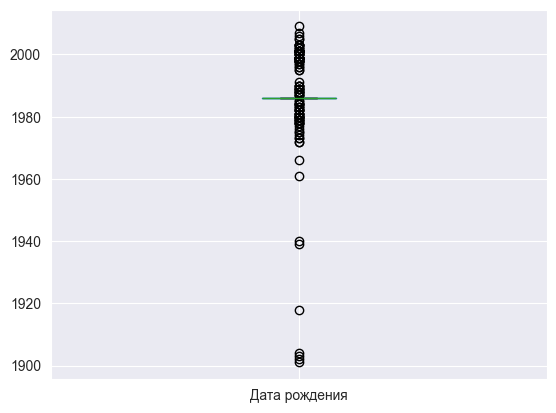

In [35]:
df.boxplot("Дата рождения")

<Axes: >

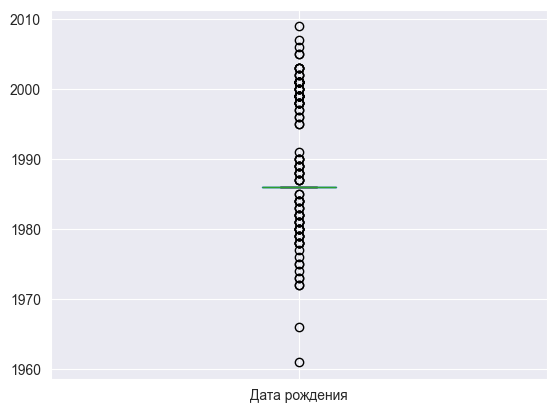

In [36]:
# Этот код устанавливает значение None для всех значений в столбце "Дата рождения", которые меньше 1960 года.
df.loc[df["Дата рождения"] < 1960, "Дата рождения"] = None

df.boxplot(column="Дата рождения")

Рассчитываем возраст на основе года рождения и анализируем распределение возраста среди пользователей через графики плотности и ящик с усами. Обрабатываем пропуски, заменяя их на нули или другие значимые значения.

In [37]:
current_year = 2024
df["Возраст"] = current_year - df["Дата рождения"]

# df = df.rename(columns={"Дата рождения": "Возраст"})

# df.boxplot(column="Возраст")

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/2861291115.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["Возраст"], shade=True, ax=axes[0])


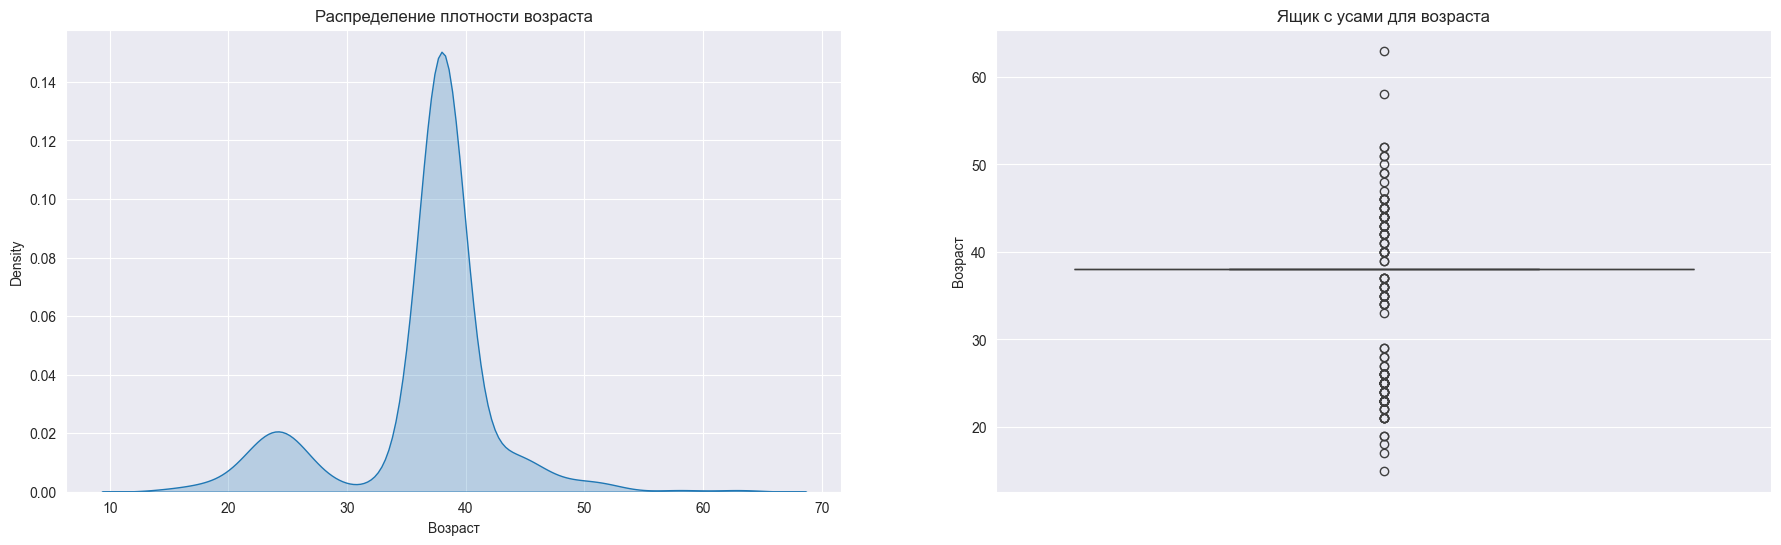

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))

sns.kdeplot(df["Возраст"], shade=True, ax=axes[0])
axes[0].set_title('Распределение плотности возраста')

sns.boxplot(y=df["Возраст"], ax=axes[1])
axes[1].set_title('Ящик с усами для возраста')

plt.show()

In [39]:
# Выводим процент пропущенных значений

missing_percentage = df["Возраст"].isnull().sum() / df.shape[0] * 100
print(f'Процент пропущенных значений в колонке "Возраст" : {missing_percentage}')


Процент пропущенных значений в колонке "Возраст" : 1.7500000000000002


In [40]:
df["Возраст"].fillna(0, inplace=True)

df.head()

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/4047274334.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Возраст"].fillna(0, inplace=True)


,id,Есть номер,Подписчики,Общие друзья,Родной город,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Дата рождения,Страна,Неактивная страница,Группы,Подписки,Возраст
0,800367,1.0,741.0,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,1986.0,NaN,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0
1,3677059,1.0,309.0,3.0,NaN,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,1986.0,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0
2,5243790,1.0,703.0,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,1986.0,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0
3,8888273,1.0,NaN,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,1986.0,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0
4,10738440,1.0,530.0,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,1999.0,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0


In [41]:
df.drop(columns=["Дата рождения"], inplace=True)

In [42]:
df

,id,Есть номер,Подписчики,Общие друзья,Родной город,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Страна,Неактивная страница,Группы,Подписки,Возраст
0,800367,1.0,741.0,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0
1,3677059,1.0,309.0,3.0,NaN,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0
2,5243790,1.0,703.0,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0
3,8888273,1.0,NaN,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0
4,10738440,1.0,530.0,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,1.0,795.0,1.0,Севастополь,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,False,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0
396,1685737,1.0,4384.0,1.0,Лучший в мире город - город на Неве!))),"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,False,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0
397,1688008,1.0,1402.0,1.0,СПб,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,False,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0
398,1703036,1.0,407.0,1.0,Казань-Санкт-Петербург,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,False,"{'id': 1, 'title': 'Россия'}",NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0


Исправляем и анализируем данные о стране. Заменяем пропущенные и некорректные значения, удаляем ненужные данные, чтобы упростить модель данных

In [43]:
df['Страна'] = df['Страна'].fillna('{"id":-1,"title":null}').apply(lambda x: json.loads(x.replace("'", '"'))['title'])
df

,id,Есть номер,Подписчики,Общие друзья,Родной город,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Страна,Неактивная страница,Группы,Подписки,Возраст
0,800367,1.0,741.0,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,None,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0
1,3677059,1.0,309.0,3.0,NaN,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,Россия,NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0
2,5243790,1.0,703.0,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,Россия,NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0
3,8888273,1.0,NaN,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,Россия,NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0
4,10738440,1.0,530.0,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,Россия,NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,1.0,795.0,1.0,Севастополь,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,False,Россия,NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0
396,1685737,1.0,4384.0,1.0,Лучший в мире город - город на Неве!))),"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,False,Россия,NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0
397,1688008,1.0,1402.0,1.0,СПб,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,False,Россия,NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0
398,1703036,1.0,407.0,1.0,Казань-Санкт-Петербург,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,False,Россия,NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0


In [44]:
df['Страна'].value_counts(dropna=False)

Страна
Россия       331
None          53
США            3
Сербия         2
Беларусь       2
Швеция         1
Молдова        1
Венгрия        1
Австралия      1
Ниуэ           1
Иордания       1
Польша         1
Бразилия       1
Германия       1
Name: count, dtype: int64

In [45]:
df.drop(columns=['Страна'], inplace=True)

df.head()

,id,Есть номер,Подписчики,Общие друзья,Родной город,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Неактивная страница,Группы,Подписки,Возраст
0,800367,1.0,741.0,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0
1,3677059,1.0,309.0,3.0,NaN,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0
2,5243790,1.0,703.0,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0
3,8888273,1.0,NaN,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0
4,10738440,1.0,530.0,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0


Удаляем данные о наличии номера телефона пользователя, так как они могут быть не релевантны для дальнейшего анализа.

In [46]:
df['Есть номер'].value_counts(dropna=False)

Есть номер
1.0    385
0.0     11
NaN      4
Name: count, dtype: int64

In [47]:
df.drop(columns=['Есть номер'], inplace=True)

df.head()

,id,Подписчики,Общие друзья,Родной город,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Неактивная страница,Группы,Подписки,Возраст
0,800367,741.0,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0
1,3677059,309.0,3.0,NaN,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0
2,5243790,703.0,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0
3,8888273,NaN,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0
4,10738440,530.0,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0


Анализируем количество подписчиков через графики, заполняем пропуски средним значением и преобразуем данные в целочисленный тип для удобства работы.

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/4100091697.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["Подписчики"], shade=True, ax=axes[0])


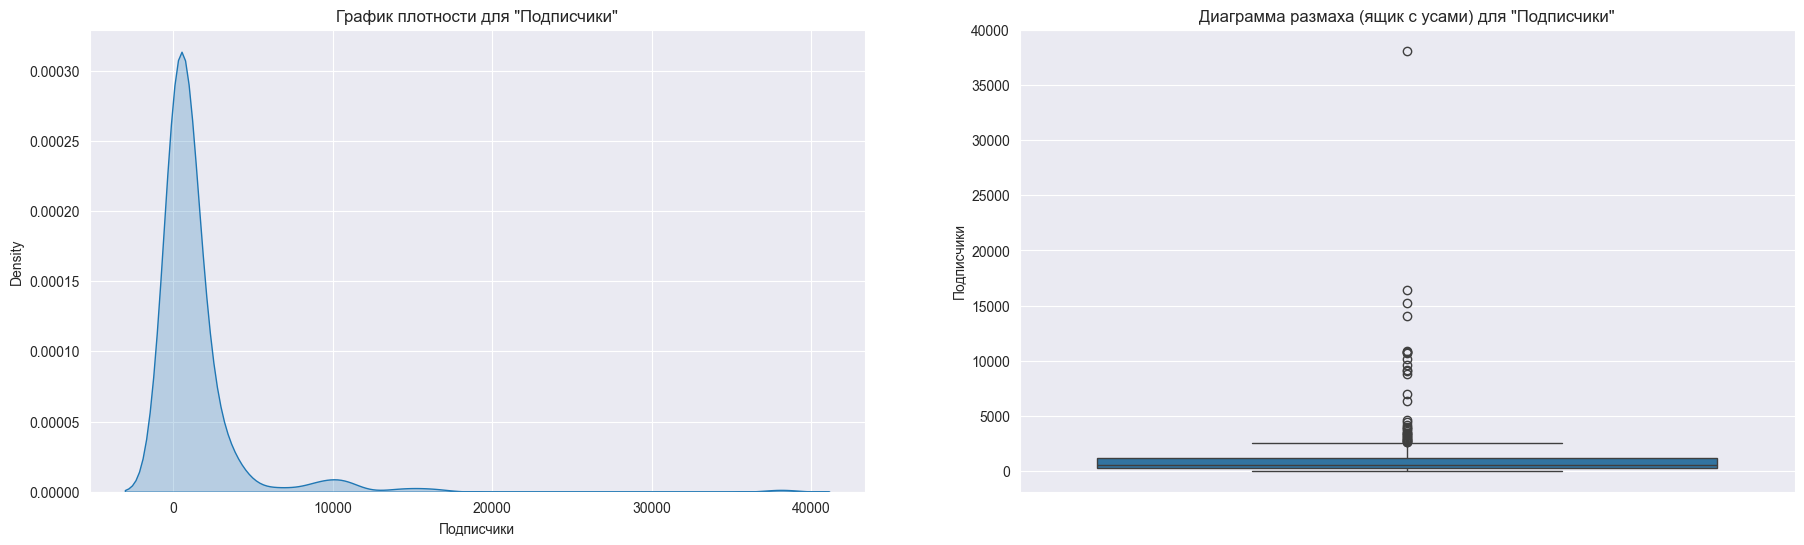

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))

sns.kdeplot(df["Подписчики"], shade=True, ax=axes[0])
axes[0].set_title('График плотности для "Подписчики"')

sns.boxplot(y=df["Подписчики"], ax=axes[1])
axes[1].set_title('Диаграмма размаха (ящик с усами) для "Подписчики"')

plt.show()

In [49]:
print(f'Доля пропущенных значений: {df["Подписчики"].isnull().sum() / df.shape[0] * 100:.2f}%')

Доля пропущенных значений: 25.00%


In [50]:
# заменяем пропущенные значения в столбце "Подписчики" на среднее значение этого столбца, округленное до ближайшего целого числа.
df["Подписчики"].fillna(round(df["Подписчики"].mean()), inplace=True)

df.head()

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/1687059111.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Подписчики"].fillna(round(df["Подписчики"].mean()), inplace=True)


,id,Подписчики,Общие друзья,Родной город,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Неактивная страница,Группы,Подписки,Возраст
0,800367,741.0,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0
1,3677059,309.0,3.0,NaN,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0
2,5243790,703.0,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0
3,8888273,1389.0,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0
4,10738440,530.0,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0


In [51]:
df['Подписчики'] = df['Подписчики'].astype(int)

df.head()

,id,Подписчики,Общие друзья,Родной город,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Неактивная страница,Группы,Подписки,Возраст
0,800367,741,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0
1,3677059,309,3.0,NaN,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0
2,5243790,703,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0
3,8888273,1389,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0
4,10738440,530,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0


Анализируем и обрабатываем данные о количестве общих друзей, стандартизируем и очищаем данные для точности последующих вычислений.

In [52]:
print(f"Процент отсутствующих данных: {df['Общие друзья'].isnull().mean() * 100:.2f}%")

Процент отсутствующих данных: 1.00%


In [53]:
df = df.dropna(subset=["Общие друзья"])

df

,id,Подписчики,Общие друзья,Родной город,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Неактивная страница,Группы,Подписки,Возраст
0,800367,741,2.0,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0
1,3677059,309,3.0,NaN,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0
2,5243790,703,3.0,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0
3,8888273,1389,0.0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0
4,10738440,530,1.0,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1.0,Севастополь,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,False,NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0
396,1685737,4384,1.0,Лучший в мире город - город на Неве!))),"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,False,NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0
397,1688008,1402,1.0,СПб,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,False,NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0
398,1703036,407,1.0,Казань-Санкт-Петербург,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,False,NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0


/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/3914215938.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["Общие друзья"], shade=True, ax=axes[0])


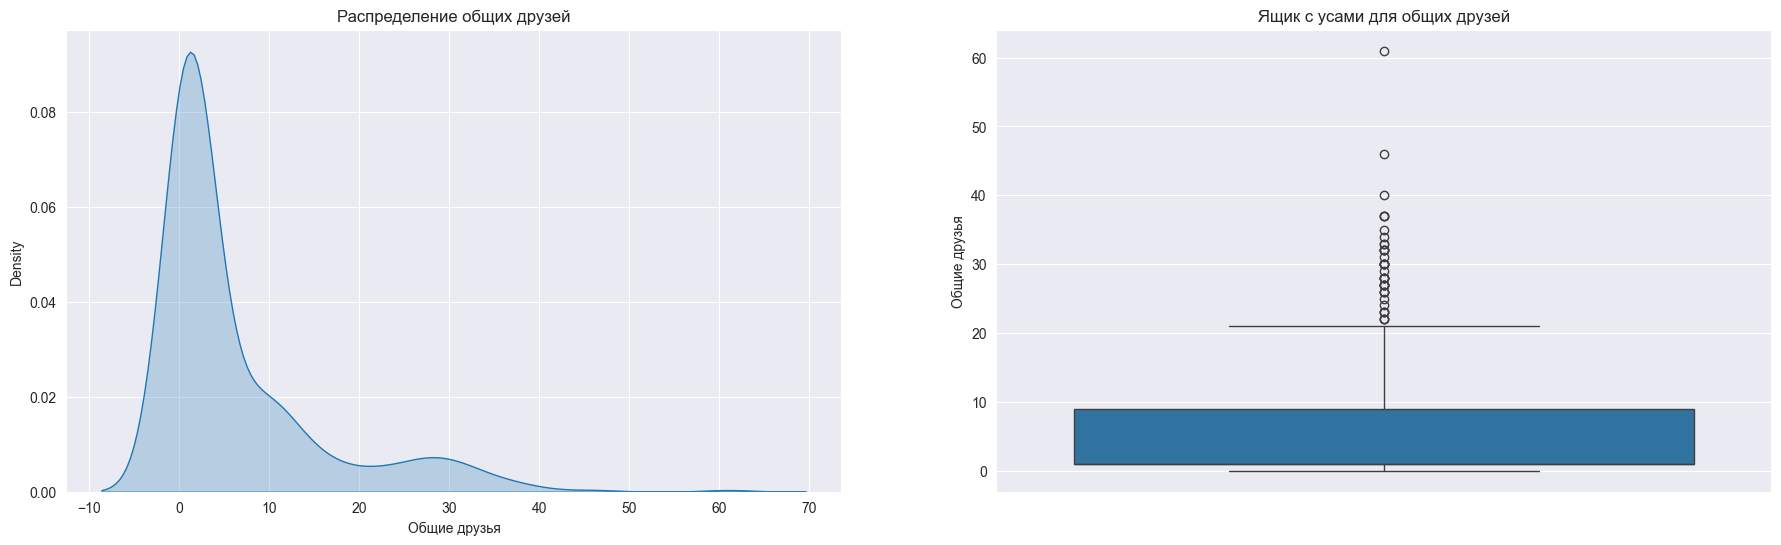

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))

sns.kdeplot(df["Общие друзья"], shade=True, ax=axes[0])
axes[0].set_title('Распределение общих друзей')

sns.boxplot(y=df["Общие друзья"], ax=axes[1])
axes[1].set_title('Ящик с усами для общих друзей')

plt.show()

In [55]:
df["Общие друзья"] = df["Общие друзья"].astype(int)

df

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/589334263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Общие друзья"] = df["Общие друзья"].astype(int)


,id,Подписчики,Общие друзья,Родной город,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Неактивная страница,Группы,Подписки,Возраст
0,800367,741,2,Ирпень Киевская обл.,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0
1,3677059,309,3,NaN,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0
2,5243790,703,3,Red Blue Moscow,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0
3,8888273,1389,0,NaN,NaN,NaN,NaN,2,Евгений,Высоков,True,True,NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0
4,10738440,530,1,NaN,NaN,NaN,NaN,2,Никита,Гапон,True,False,NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,Севастополь,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,False,NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0
396,1685737,4384,1,Лучший в мире город - город на Неве!))),"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,False,NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0
397,1688008,1402,1,СПб,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,False,NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0
398,1703036,407,1,Казань-Санкт-Петербург,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,False,NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0


Очищаем и анализируем данные о родном городе, удаляя нерелевантные или неполные данные.

In [56]:
print(f'Доля пропущенных значений: {df["Родной город"].isnull().mean():.2%}')

Доля пропущенных значений: 60.86%


In [57]:
df['Родной город'].value_counts(dropna=False)

Родной город
NaN                       241
Москва                     44
Санкт-Петербург            21
Ленинград                   8
Питер                       6
                         ... 
Красноярск                  1
Бугульма                    1
рязань                      1
𝔐𝔬𝔰𝔠𝔬𝔴                      1
Казань-Санкт-Петербург      1
Name: count, Length: 72, dtype: int64

In [58]:
condition = df["Родной город"].isin(["", "Москва", "москва","𝔐𝔬𝔰𝔠𝔬𝔴","Moscow", "moscow"]) | df["Родной город"].isnull()

#condition будет содержать True для строк, где значение в столбце "Родной город" соответствует одному из указанных выше условий.
print(f'Доля значений Москва или пропущенных: {condition.mean():.2%}')

Доля значений Москва или пропущенных: 73.99%


In [59]:
df.loc[~condition, "Родной город"].value_counts()

Родной город
Санкт-Петербург           21
Ленинград                  8
Питер                      6
СПб                        4
Петербург                  2
                          ..
Бугульма                   1
рязань                     1
Тольятти                   1
Уездный город К.           1
Казань-Санкт-Петербург     1
Name: count, Length: 66, dtype: int64

In [60]:
df.drop(columns="Родной город", inplace=True)

df

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/1396245883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns="Родной город", inplace=True)


,id,Подписчики,Общие друзья,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Неактивная страница,Группы,Подписки,Возраст
0,800367,741,2,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,False,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0
1,3677059,309,3,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,False,NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0
2,5243790,703,3,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,False,NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0
3,8888273,1389,0,NaN,NaN,NaN,2,Евгений,Высоков,True,True,NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0
4,10738440,530,1,NaN,NaN,NaN,2,Никита,Гапон,True,False,NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,False,NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0
396,1685737,4384,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,False,NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0
397,1688008,1402,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,False,NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0
398,1703036,407,1,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,False,NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0


In [61]:
df['Позиция'].unique()

array(["{'langs': ['Русский'], 'langs_full': [{'id': 0, 'native_name': 'Русский'}]}",
       "{'alcohol': 0, 'inspired_by': '', 'life_main': 0, 'people_main': 0, 'smoking': 0}",
       "{'alcohol': 0, 'inspired_by': '', 'langs': ['Русский', 'English'], 'langs_full': [{'id': 0, 'native_name': 'Русский'}, {'id': 3, 'native_name': 'English'}], 'life_main': 0, 'people_main': 0, 'smoking': 0}",
       nan,
       "{'alcohol': 4, 'inspired_by': '', 'langs': ['Русский'], 'langs_full': [{'id': 0, 'native_name': 'Русский'}], 'political': 3, 'religion': 'Православие', 'religion_id': 102, 'smoking': 4}",
       "{'alcohol': 0, 'inspired_by': '', 'langs': ['Русский'], 'langs_full': [{'id': 0, 'native_name': 'Русский'}], 'life_main': 0, 'people_main': 0, 'smoking': 0}",
       "{'political': 6}",
       "{'alcohol': 0, 'inspired_by': '', 'langs': ['Русский', 'English'], 'langs_full': [{'id': 0, 'native_name': 'Русский'}, {'id': 3, 'native_name': 'English'}], 'life_main': 0, 'people_main': 2, 'polit

Извлекаем и анализируем персональные данные пользователей из сложных структур JSON, включая алкоголь, вдохновение, языки и другие личные предпочтения.

In [62]:
personal_info = df['Позиция'].fillna("{}").replace("[]", "{}").apply(ast.literal_eval).apply(pd.Series)

In [63]:
df = df.join(personal_info[[
    'alcohol',
    'inspired_by',
    'langs',
    'life_main',
    'people_main',
    'political',
    'smoking',
    'religion',
    'religion_id'
    ]
                           ]
             )

df.rename(columns={
    'alcohol': 'Алкоголь',
    'inspired_by': 'Вдохновение',
    'langs': 'Языки',
    'life_main': 'Смысл жизни',
    'people_main': 'Главное в людях',
    'political': 'Политическая позиция',
    'smoking': 'Курение',
    'religion': 'Религия',
    'religion_id': 'id религии'},
          inplace=True
          )

df

,id,Подписчики,Общие друзья,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,...,Возраст,Алкоголь,Вдохновение,Языки,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия,id религии
0,800367,741,2,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,...,38.0,NaN,NaN,[Русский],NaN,NaN,NaN,NaN,NaN,NaN
1,3677059,309,3,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,...,38.0,0.0,,NaN,0.0,0.0,NaN,0.0,NaN,NaN
2,5243790,703,3,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,...,38.0,0.0,,"[Русский, English]",0.0,0.0,NaN,0.0,NaN,NaN
3,8888273,1389,0,NaN,NaN,NaN,2,Евгений,Высоков,True,...,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10738440,530,1,NaN,NaN,NaN,2,Никита,Гапон,True,...,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,...,38.0,0.0,,[Русский],6.0,0.0,6.0,0.0,язычник,NaN
396,1685737,4384,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,...,38.0,0.0,,[Русский],0.0,0.0,NaN,0.0,NaN,NaN
397,1688008,1402,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,...,38.0,0.0,,[Русский],0.0,0.0,NaN,0.0,NaN,NaN
398,1703036,407,1,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,...,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Религия - опиум для народа!,NaN


In [64]:
df['Алкоголь'].unique()

array([nan,  0.,  4.,  2.,  3.,  1.,  5.])

In [65]:
df['Алкоголь'] = df['Алкоголь'].replace(0, None).fillna(round(df['Алкоголь'].replace(0, None).mean()))

df

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/2632789138.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Алкоголь'] = df['Алкоголь'].replace(0, None).fillna(round(df['Алкоголь'].replace(0, None).mean()))


,id,Подписчики,Общие друзья,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,...,Возраст,Алкоголь,Вдохновение,Языки,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия,id религии
0,800367,741,2,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,...,38.0,3.0,NaN,[Русский],NaN,NaN,NaN,NaN,NaN,NaN
1,3677059,309,3,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,...,38.0,3.0,,NaN,0.0,0.0,NaN,0.0,NaN,NaN
2,5243790,703,3,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,...,38.0,3.0,,"[Русский, English]",0.0,0.0,NaN,0.0,NaN,NaN
3,8888273,1389,0,NaN,NaN,NaN,2,Евгений,Высоков,True,...,38.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10738440,530,1,NaN,NaN,NaN,2,Никита,Гапон,True,...,25.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,...,38.0,3.0,,[Русский],6.0,0.0,6.0,0.0,язычник,NaN
396,1685737,4384,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,...,38.0,3.0,,[Русский],0.0,0.0,NaN,0.0,NaN,NaN
397,1688008,1402,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,...,38.0,3.0,,[Русский],0.0,0.0,NaN,0.0,NaN,NaN
398,1703036,407,1,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,...,38.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Религия - опиум для народа!,NaN


In [66]:
df["Языки"].astype(str).value_counts()

Языки
nan                                                                        246
['Русский']                                                                 96
['Русский', 'English']                                                      25
['Русский', 'English', 'Deutsch']                                            5
['English']                                                                  3
['Русский', 'Deutsch', 'English']                                            1
['Deutsch']                                                                  1
['English', 'Français']                                                      1
['Русский', 'Вадун аруу']                                                    1
['Русский', 'English', 'Suomi']                                              1
['Русский', '汉语']                                                            1
['Italiano', 'English', 'Français', 'Deutsch', 'Suomi', 'Eesti', '日本語']      1
['Русский', 'English', 'Español']             

In [67]:
df.drop(columns=['Языки'], inplace=True)

df

,id,Подписчики,Общие друзья,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,...,Подписки,Возраст,Алкоголь,Вдохновение,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия,id религии
0,800367,741,2,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,...,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3677059,309,3,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,...,"[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0,3.0,,0.0,0.0,NaN,0.0,NaN,NaN
2,5243790,703,3,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,...,"[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0,3.0,,0.0,0.0,NaN,0.0,NaN,NaN
3,8888273,1389,0,NaN,NaN,NaN,2,Евгений,Высоков,True,...,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10738440,530,1,NaN,NaN,NaN,2,Никита,Гапон,True,...,"[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,...,"[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0,3.0,,6.0,0.0,6.0,0.0,язычник,NaN
396,1685737,4384,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,...,"[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0,3.0,,0.0,0.0,NaN,0.0,NaN,NaN
397,1688008,1402,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,...,"[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0,3.0,,0.0,0.0,NaN,0.0,NaN,NaN
398,1703036,407,1,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,...,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0,3.0,NaN,NaN,NaN,NaN,NaN,Религия - опиум для народа!,NaN


In [68]:
meanings_of_life = {
    1: "Семья и дети",
    2: "Карьера и деньги",
    3: "Развлечение и отдых",
    4: "Наука и исследования",
    5: "Совершенствование мира",
    6: "Саморазвитие",
    7: "Красота и искусство",
    8: "Слава и влияние"
    }

In [69]:
df['Смысл жизни'] = df['Смысл жизни'].replace(0, None).replace(meanings_of_life)

df["Смысл жизни"]

0               NaN
1              None
2              None
3               NaN
4               NaN
           ...     
395    Саморазвитие
396            None
397            None
398             NaN
399             NaN
Name: Смысл жизни, Length: 396, dtype: object

In [70]:
df["Смысл жизни"].value_counts()

Смысл жизни
Саморазвитие              13
Семья и дети               7
Развлечение и отдых        5
Совершенствование мира     5
Карьера и деньги           4
Наука и исследования       4
Красота и искусство        4
Слава и влияние            1
Name: count, dtype: int64

In [71]:
df["Смысл жизни"].isnull().sum()

np.int64(353)

In [72]:
values_in_people = {
    1: "Ум и креативность",
    2: "Доброта и честность",
    3: "Красота и здоровье",
    4: "Власть и богатство",
    5: "Смелость и упорство",
    6: "Юмор и жизнелюбие"
    }

In [73]:
df['Главное в людях'] = df['Главное в людях'].replace(0, None).replace(values_in_people)

df["Главное в людях"]

0       NaN
1      None
2      None
3       NaN
4       NaN
       ... 
395    None
396    None
397    None
398     NaN
399     NaN
Name: Главное в людях, Length: 396, dtype: object

In [74]:
df["Главное в людях"].isnull().sum()

np.int64(353)

In [75]:
df["Главное в людях"].value_counts()

Главное в людях
Доброта и честность    21
Юмор и жизнелюбие       9
Смелость и упорство     5
Ум и креативность       5
Красота и здоровье      2
Власть и богатство      1
Name: count, dtype: int64

In [76]:
political_positions = {
    1: "Коммунизм",
    2: "Социализм",
    3: "Аполитическая",
    4: "Либерализм",
    5: "Консерватизм",
    6: "Монархия",
    7: "Ультраконсерватизм",
    8: "Аполитическая",
    9: "Либертарианство"
    }

In [77]:
df['Политическая позиция'] = df['Политическая позиция'].replace(0, None).replace(political_positions)

df["Политическая позиция"]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
395    Монархия
396         NaN
397         NaN
398         NaN
399         NaN
Name: Политическая позиция, Length: 396, dtype: object

In [78]:
df["Главное в людях"].isnull().sum()

np.int64(353)

In [79]:
df['Курение'] = df['Курение'].replace(0, None).fillna(round(df['Курение'].replace(0, None).mean()))

df

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/1183388048.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Курение'] = df['Курение'].replace(0, None).fillna(round(df['Курение'].replace(0, None).mean()))


,id,Подписчики,Общие друзья,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,...,Подписки,Возраст,Алкоголь,Вдохновение,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия,id религии
0,800367,741,2,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,...,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN
1,3677059,309,3,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,...,"[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0,3.0,,None,None,NaN,3.0,NaN,NaN
2,5243790,703,3,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,...,"[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0,3.0,,None,None,NaN,3.0,NaN,NaN
3,8888273,1389,0,NaN,NaN,NaN,2,Евгений,Высоков,True,...,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN
4,10738440,530,1,NaN,NaN,NaN,2,Никита,Гапон,True,...,"[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,...,"[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0,3.0,,Саморазвитие,None,Монархия,3.0,язычник,NaN
396,1685737,4384,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,...,"[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0,3.0,,None,None,NaN,3.0,NaN,NaN
397,1688008,1402,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,...,"[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0,3.0,,None,None,NaN,3.0,NaN,NaN
398,1703036,407,1,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,...,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,Религия - опиум для народа!,NaN


In [80]:
df["id религии"].notnull().sum()

np.int64(16)

In [81]:
df.drop(columns=['id религии'], inplace=True)

In [82]:
df["Религия"].notnull().sum()

np.int64(32)

In [83]:
df["Религия"].value_counts()

Религия
Православие                    11
Агностицизм                     2
Пастафарианство                 2
Боженьку люблю! 187330          1
язычник                         1
Я верю в Свет!                  1
Иудейство и Евреизм             1
Верю в мечту ;)                 1
                               1
нет                             1
Католицизм                      1
Культ священной табуретки       1
Iggy pop                        1
ыдялгзв  еынзоигилер            1
Либеральный феминизм            1
Mac OS X                        1
живи и дай жить другим.         1
Буддизм                         1
Неоязычество (Викка)            1
Религия - опиум для народа!     1
Name: count, dtype: int64

In [84]:
df

,id,Подписчики,Общие друзья,Позиция,ВУЗы,Школы,Пол,Имя,Фамилия,Доступ к закрытому профилю,...,Группы,Подписки,Возраст,Алкоголь,Вдохновение,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия
0,800367,741,2,"{'langs': ['Русский'], 'langs_full': [{'id': 0...","[{'city': 314, 'country': 0, 'id': 10637, 'nam...",[],2,Виталий,Чоботок,True,...,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
1,3677059,309,3,"{'alcohol': 0, 'inspired_by': '', 'life_main':...","[{'city': 1, 'country': 1, 'id': 348, 'name': ...","[{'city': 625, 'class': '', 'class_id': 0, 'co...",1,Анастасия,Мехова,True,...,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0,3.0,,None,None,NaN,3.0,NaN
2,5243790,703,3,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 1, 'country': 1, 'education_form': '...","[{'city': 1, 'class': 'б', 'class_id': 2, 'cou...",2,Дмитрий,Федин,True,...,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
3,8888273,1389,0,NaN,NaN,NaN,2,Евгений,Высоков,True,...,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
4,10738440,530,1,NaN,NaN,NaN,2,Никита,Гапон,True,...,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 70867, 'chair_name': 'Информационны...","[{'city': 185, 'class': 'а', 'class_id': 1, 'c...",2,Александр,Гончаров,True,...,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0,3.0,,Саморазвитие,None,Монархия,3.0,язычник
396,1685737,4384,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 1805223, 'chair_name': 'Режиссуры и...",[],1,Ольга,Трофимова,True,...,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0,3.0,,None,None,NaN,3.0,NaN
397,1688008,1402,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64528, 'chair_name': 'Автоматизации...","[{'city': 87, 'class': 'в', 'class_id': 3, 'co...",1,Ирина,Михайлова,True,...,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
398,1703036,407,1,{'religion': 'Религия - опиум для народа!'},[],[],2,Айдар,Абдрахманов,True,...,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,Религия - опиум для народа!


In [85]:
df.drop(columns=["ВУЗы", "Школы"], inplace=True)

In [86]:
df

,id,Подписчики,Общие друзья,Позиция,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Неактивная страница,Группы,Подписки,Возраст,Алкоголь,Вдохновение,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия
0,800367,741,2,"{'langs': ['Русский'], 'langs_full': [{'id': 0...",2,Виталий,Чоботок,True,False,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
1,3677059,309,3,"{'alcohol': 0, 'inspired_by': '', 'life_main':...",1,Анастасия,Мехова,True,False,NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0,3.0,,None,None,NaN,3.0,NaN
2,5243790,703,3,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...",2,Дмитрий,Федин,True,False,NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
3,8888273,1389,0,NaN,2,Евгений,Высоков,True,True,NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
4,10738440,530,1,NaN,2,Никита,Гапон,True,False,NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...",2,Александр,Гончаров,True,False,NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0,3.0,,Саморазвитие,None,Монархия,3.0,язычник
396,1685737,4384,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...",1,Ольга,Трофимова,True,False,NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0,3.0,,None,None,NaN,3.0,NaN
397,1688008,1402,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...",1,Ирина,Михайлова,True,False,NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
398,1703036,407,1,{'religion': 'Религия - опиум для народа!'},2,Айдар,Абдрахманов,True,False,NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,Религия - опиум для народа!


In [87]:
open_profiles = df["Доступ к закрытому профилю"] != False

In [88]:
open_profiles.sum()

np.int64(355)

In [89]:
# Фильтруем закрытые профили
df = df[open_profiles]

df

,id,Подписчики,Общие друзья,Позиция,Пол,Имя,Фамилия,Доступ к закрытому профилю,Закрытый профиль,Неактивная страница,Группы,Подписки,Возраст,Алкоголь,Вдохновение,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия
0,800367,741,2,"{'langs': ['Русский'], 'langs_full': [{'id': 0...",2,Виталий,Чоботок,True,False,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
1,3677059,309,3,"{'alcohol': 0, 'inspired_by': '', 'life_main':...",1,Анастасия,Мехова,True,False,NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0,3.0,,None,None,NaN,3.0,NaN
2,5243790,703,3,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...",2,Дмитрий,Федин,True,False,NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
3,8888273,1389,0,NaN,2,Евгений,Высоков,True,True,NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
4,10738440,530,1,NaN,2,Никита,Гапон,True,False,NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...",2,Александр,Гончаров,True,False,NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0,3.0,,Саморазвитие,None,Монархия,3.0,язычник
396,1685737,4384,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...",1,Ольга,Трофимова,True,False,NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0,3.0,,None,None,NaN,3.0,NaN
397,1688008,1402,1,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...",1,Ирина,Михайлова,True,False,NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
398,1703036,407,1,{'religion': 'Религия - опиум для народа!'},2,Айдар,Абдрахманов,True,False,NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,Религия - опиум для народа!


In [90]:
# удаляем лишние колонки
df.drop(columns=["Закрытый профиль", "Доступ к закрытому профилю", 'Позиция'], inplace=True)

df

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/1536941659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["Закрытый профиль", "Доступ к закрытому профилю", 'Позиция'], inplace=True)


,id,Подписчики,Общие друзья,Пол,Имя,Фамилия,Неактивная страница,Группы,Подписки,Возраст,Алкоголь,Вдохновение,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия
0,800367,741,2,2,Виталий,Чоботок,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
1,3677059,309,3,1,Анастасия,Мехова,NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0,3.0,,None,None,NaN,3.0,NaN
2,5243790,703,3,2,Дмитрий,Федин,NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
3,8888273,1389,0,2,Евгений,Высоков,NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
4,10738440,530,1,2,Никита,Гапон,NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,2,Александр,Гончаров,NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0,3.0,,Саморазвитие,None,Монархия,3.0,язычник
396,1685737,4384,1,1,Ольга,Трофимова,NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0,3.0,,None,None,NaN,3.0,NaN
397,1688008,1402,1,1,Ирина,Михайлова,NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
398,1703036,407,1,2,Айдар,Абдрахманов,NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,Религия - опиум для народа!


In [91]:
df[df["Неактивная страница"].isnull()]

,id,Подписчики,Общие друзья,Пол,Имя,Фамилия,Неактивная страница,Группы,Подписки,Возраст,Алкоголь,Вдохновение,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия
0,800367,741,2,2,Виталий,Чоботок,NaN,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
1,3677059,309,3,1,Анастасия,Мехова,NaN,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0,3.0,,None,None,NaN,3.0,NaN
2,5243790,703,3,2,Дмитрий,Федин,NaN,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
3,8888273,1389,0,2,Евгений,Высоков,NaN,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
4,10738440,530,1,2,Никита,Гапон,NaN,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,2,Александр,Гончаров,NaN,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0,3.0,,Саморазвитие,None,Монархия,3.0,язычник
396,1685737,4384,1,1,Ольга,Трофимова,NaN,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0,3.0,,None,None,NaN,3.0,NaN
397,1688008,1402,1,1,Ирина,Михайлова,NaN,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
398,1703036,407,1,2,Айдар,Абдрахманов,NaN,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,Религия - опиум для народа!


In [92]:
df.drop(columns=["Неактивная страница"], inplace=True)

df

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/3439192732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["Неактивная страница"], inplace=True)


,id,Подписчики,Общие друзья,Пол,Имя,Фамилия,Группы,Подписки,Возраст,Алкоголь,Вдохновение,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия
0,800367,741,2,2,Виталий,Чоботок,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
1,3677059,309,3,1,Анастасия,Мехова,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0,3.0,,None,None,NaN,3.0,NaN
2,5243790,703,3,2,Дмитрий,Федин,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
3,8888273,1389,0,2,Евгений,Высоков,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
4,10738440,530,1,2,Никита,Гапон,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,2,Александр,Гончаров,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0,3.0,,Саморазвитие,None,Монархия,3.0,язычник
396,1685737,4384,1,1,Ольга,Трофимова,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0,3.0,,None,None,NaN,3.0,NaN
397,1688008,1402,1,1,Ирина,Михайлова,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
398,1703036,407,1,2,Айдар,Абдрахманов,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,Религия - опиум для народа!


Производим извлечение и анализ текстовой информации из данных о группах и подписках, применяя методы обработки текста для выделения значимых слов и фраз.

In [93]:
df["Группы"].dtypes

dtype('O')

In [94]:
df['Группы'] = df['Группы'].replace(0, None)

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/870682329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Группы'] = df['Группы'].replace(0, None)


In [95]:
df

,id,Подписчики,Общие друзья,Пол,Имя,Фамилия,Группы,Подписки,Возраст,Алкоголь,Вдохновение,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия
0,800367,741,2,2,Виталий,Чоботок,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
1,3677059,309,3,1,Анастасия,Мехова,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0,3.0,,None,None,NaN,3.0,NaN
2,5243790,703,3,2,Дмитрий,Федин,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
3,8888273,1389,0,2,Евгений,Высоков,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
4,10738440,530,1,2,Никита,Гапон,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,2,Александр,Гончаров,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0,3.0,,Саморазвитие,None,Монархия,3.0,язычник
396,1685737,4384,1,1,Ольга,Трофимова,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0,3.0,,None,None,NaN,3.0,NaN
397,1688008,1402,1,1,Ирина,Михайлова,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
398,1703036,407,1,2,Айдар,Абдрахманов,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,Религия - опиум для народа!


In [96]:
df['Группы'].isna().sum()

np.int64(31)

In [97]:
# df = df.dropna(subset=['Группы'])

In [98]:
df

,id,Подписчики,Общие друзья,Пол,Имя,Фамилия,Группы,Подписки,Возраст,Алкоголь,Вдохновение,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия
0,800367,741,2,2,Виталий,Чоботок,NaN,"[{""id"": 219254113, ""description"": ""\u0420\u043...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
1,3677059,309,3,1,Анастасия,Мехова,"[{""id"": 211232966, ""description"": ""\u2022 \u04...","[{""id"": 211232966, ""description"": ""\u2022 \u04...",38.0,3.0,,None,None,NaN,3.0,NaN
2,5243790,703,3,2,Дмитрий,Федин,"[{""id"": 23693281, ""description"": ""\u0423\u0436...","[{""id"": 218184104, ""description"": ""\u0410\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
3,8888273,1389,0,2,Евгений,Высоков,"[{""id"": 42923159, ""description"": ""\u0412 2011 ...","[{""id"": 42923159, ""description"": ""\u0412 2011 ...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
4,10738440,530,1,2,Никита,Гапон,"[{""id"": 211835756, ""description"": ""\u00ab\u041...","[{""id"": 85251453, ""description"": ""\u041d\u0435...",25.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,2,Александр,Гончаров,"[{""id"": 219309149, ""description"": ""\u042f \u04...","[{""id"": 219309149, ""description"": ""\u042f \u04...",38.0,3.0,,Саморазвитие,None,Монархия,3.0,язычник
396,1685737,4384,1,1,Ольга,Трофимова,"[{""id"": 38091858, ""description"": ""\u0432 \u043...","[{""id"": 38091858, ""description"": ""\u0432 \u043...",38.0,3.0,,None,None,NaN,3.0,NaN
397,1688008,1402,1,1,Ирина,Михайлова,"[{""id"": 272049, ""description"": ""\u27a1\ufe0f \...","[{""id"": 199807922, ""description"": ""\u041f\u043...",38.0,3.0,,None,None,NaN,3.0,NaN
398,1703036,407,1,2,Айдар,Абдрахманов,"[{""id"": 183031, ""description"": ""\u041d\u043e\u...","[{""id"": 183031, ""description"": ""\u041d\u043e\u...",38.0,3.0,NaN,NaN,NaN,NaN,3.0,Религия - опиум для народа!


In [99]:
# Вывод значения в первой строке столбца "Группы"
first_group_value = df["Группы"].iloc[1]

print("Значение в первой строке столбца 'Группы':", first_group_value)

Значение в первой строке столбца 'Группы': [{"id": 211232966, "description": "\u2022 \u0423\u0442\u0440\u0435\u043d\u043d\u0435\u0435 \u0448\u043e\u0443\n\u2022 \u0424\u0430\u0441\u0442\u043c\u0443\u0434\n\u2022 \u0418\u043d\u0441\u0442\u0438\u0442\u0443\u0442 \u0442\u0435\u043b\u0435\u0432\u0438\u0434\u0435\u043d\u0438\u044f\n\u2022 12 \u0432\u043e\u043f\u0440\u043e\u0441\u043e\u0432\n\u2022 \u041c\u0435\u0436\u0434\u0443 \u043d\u0430\u043c\u0438\n\u2022 \u041d\u0430\u0442\u0430\u043b\u044c\u043d\u0430\u044f \u043a\u0430\u0440\u0442\u0430\n\n\u041f\u043e \u0432\u043e\u043f\u0440\u043e\u0441\u0430\u043c \u0440\u0435\u043a\u043b\u0430\u043c\u044b \u0438 \u043a\u043e\u043c\u043c\u0435\u0440\u0447\u0435\u0441\u043a\u0438\u0445 \u043f\u0440\u0435\u0434\u043b\u043e\u0436\u0435\u043d\u0438\u0439, \u043f\u043e\u0436\u0430\u043b\u0443\u0439\u0441\u0442\u0430 \u043f\u0438\u0448\u0438\u0442\u0435 \u043d\u0430 SalesVkVideo@vk.company", "activity": "\u0428\u043e\u0443, \u043f\u0435\u0440\u0435\u04

In [100]:
# Замена пропущенных значений в колонке "Группы" на пустой список
df["Группы"].fillna('[]', inplace=True)


/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/3506297389.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Группы"].fillna('[]', inplace=True)
/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/3506297389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Группы"].fillna('[]', inplace=True)


In [101]:
# # Преобразование JSON-строк в словарь и создание нового DataFrame
# df_groups = pd.DataFrame(df["Группы"].apply(json.loads).tolist())


# Преобразование списков в словари и создание нового DataFrame
df_groups = pd.DataFrame(df["Группы"].apply(lambda x: {} if pd.isnull(x) else json.loads(x)).tolist())

df_groups

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"{'id': 211232966, 'description': '• Утреннее ш...","{'id': 161486117, 'description': 'Телеграм-кан...","{'id': 187496359, 'description': 'Плаваем в эк...","{'id': 204130479, 'description': 'Давай делать...","{'id': 37633522, 'description': 'Мониторинг эк...","{'id': 206705410, 'description': 'Ozon fresh -...","{'id': 172367614, 'description': 'Unluko maluk...","{'id': 210897153, 'description': 'Это сообщест...","{'id': 15111376, 'description': 'Официальный а...","{'id': 199136274, 'description': 'Псс, нужен к...",...,None,None,None,None,None,None,None,None,None,None
2,"{'id': 23693281, 'description': 'Уже 12 лет мы...","{'id': 79665083, 'description': 'Официальная г...","{'id': 218184104, 'description': 'Авторские ил...","{'id': 53109527, 'description': 'Знаем о рэпе ...","{'id': 83132966, 'description': 'РЭС 2024: I) ...","{'id': 144260965, 'description': 'Невероятный ...","{'id': 34160368, 'description': 'Крупнейшее со...","{'id': 125004421, 'description': '', 'activity...","{'id': 135209264, 'description': 'Лучший бот В...","{'id': 53316211, 'description': 'Велобарахолка...",...,None,None,None,None,None,None,None,None,None,None
3,"{'id': 42923159, 'description': 'В 2011 мы реш...","{'id': 120547275, 'description': 'SINGLE ""Стра...","{'id': 50445234, 'description': 'Новости город...","{'id': 65974416, 'description': 'Ежедневные но...","{'id': 128651204, 'description': 'Председатель...","{'id': 159078357, 'description': 'Наша группа ...","{'id': 175402540, 'description': 'Журнал выпус...","{'id': 115718282, 'description': 'Самые интере...","{'id': 31794821, 'description': 'Сообщество по...","{'id': 187819042, 'description': 'Никакой агит...",...,None,None,None,None,None,None,None,None,None,None
4,"{'id': 211835756, 'description': '«День финанс...","{'id': 85251453, 'description': 'Немножко брут...","{'id': 222542899, 'description': 'https://band...","{'id': 40800148, 'description': 'Юмор на злобу...","{'id': 64462116, 'description': 'Здесь только ...","{'id': 161577578, 'description': 'Наш телеграм...","{'id': 29544671, 'description': 'Уже 12 лет пе...","{'id': 101076461, 'description': 'Главное сооб...","{'id': 136079871, 'description': 'Объявления С...","{'id': 18830783, 'description': 'Мы самая гром...",...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,"{'id': 219309149, 'description': 'Я здесь, что...","{'id': 211437014, 'description': '💰 Любая хуйн...","{'id': 18721404, 'description': '""Wookiees!"" -...","{'id': 9828339, 'description': 'Лидер обществе...","{'id': 35862441, 'description': '#Art@darkbeau...","{'id': 38233726, 'description': '', 'activity'...","{'id': 219465931, 'description': '🏆 Подпишись ...","{'id': 72911622, 'description': 'Добро пожалов...","{'id': 76281904, 'description': 'Как предложит...","{'id': 909692, 'description': 'Генерала Остряк...",...,None,None,None,None,None,None,None,None,None,None
351,"{'id': 38091858, 'description': 'в миг, когда ...","{'id': 38857960, 'description': 'Любовь долгот...","{'id': 23387450, 'description': '', 'activity'...","{'id': 43849838, 'description': '', 'activity'...","{'id': 30504651, 'description': 'Это сообществ...","{'id': 40886007, 'description': 'Академическое...","{'id': 34815360, 'description': 'Сообщество об...","{'id': 33294101, 'description': '', 'activity'...","{'id': 207853520, 'description': 'Всё и животн...","{'id': 169982369, 'description': 'Молодежный т...",...,None,None,None,None,None,None,None,None,None,None
352,"{'id': 272049, 'description': '➡️ Разместить п...","{'id': 43682523, 'description': 'Первое русско...","{'id': 36507793, 'description': 'Все, что вы х...","{'id': 47256091, 'description': 'Космос — это ...","{'id': 23984425, 'description': 'Группа с наши...","{'id': 547329

In [102]:
t = pd.DataFrame(json.loads(df["Группы"].iloc[1])).query('name == "Netflix"')
t


,id,description,activity,name,screen_name,is_closed,type,photo_50,photo_100,photo_200
1,161486117,Телеграм-канал: t.me/Tvnetflix,Кино,Netflix,tvnetflix,0,page,https://sun1-85.userapi.com/s/v1/if1/RSBR4FyFU...,https://sun1-85.userapi.com/s/v1/if1/fESBs-Lu5...,https://sun1-85.userapi.com/s/v1/if1/xLMz2arbY...


In [103]:
def extract_text_data(json_string):
    """
    Извлекает и объединяет текстовые данные из полей 'name', 'description' и 'activity' в JSON-строке.
    """
    if json_string == "[]":
        return ""
    try:
        data = pd.DataFrame(json.loads(json_string))
        pattern = r"(\w*[ЦцКкНнГгШшЩщЗзХхФфВвПпРрЛлДдЖжЧчСсМмТтБб])[УуЕеЫыАаОоЭэЯяИиЬьЮюЯяЙй]*"
        for col in ['name', 'description', 'activity']:
            data[col] = data[col].fillna("").apply(
                lambda x: " ".join(
                    x.lower() for x in re.findall(pattern, x)
                    )
                )
        data['combined'] = data['name'] + " " + data['description'] + " " + data['activity']
        return data['combined'].str.strip().sum()
    except:
        return ""

In [104]:
df['Группы'] = df['Группы'].fillna("[]").apply(extract_text_data)
df['Подписки'] = df['Подписки'].fillna("[]").apply(extract_text_data)

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/2238323765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Группы'] = df['Группы'].fillna("[]").apply(extract_text_data)
/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/2238323765.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Подписки'] = df['Подписки'].fillna("[]").apply(extract_text_data)


In [105]:
df

,id,Подписчики,Общие друзья,Пол,Имя,Фамилия,Группы,Подписки,Возраст,Алкоголь,Вдохновение,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия
0,800367,741,2,2,Виталий,Чоботок,,держав рок поп групп с русск душ котор пишет п...,38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
1,3677059,309,3,1,Анастасия,Мехова,натальн карт утренн ш фастмуд институт телевид...,натальн карт утренн ш фастмуд институт телевид...,38.0,3.0,,None,None,NaN,3.0,NaN
2,5243790,703,3,2,Дмитрий,Федин,футбол европ уж лет м пишем европейском футбол...,ольг королев иллюстратор авторск иллюстрац дл ...,38.0,3.0,,None,None,NaN,3.0,NaN
3,8888273,1389,0,2,Евгений,Высоков,в м решил создат единственн в эт стран см кото...,в м решил создат единственн в эт стран см кото...,38.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
4,10738440,530,1,2,Никита,Гапон,ден финансов грамотност ден финансов грамотнос...,мужск характер немножк брутальност н повредит ...,25.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,2,Александр,Гончаров,антонов так антонов здес чтоб пит коф сделат и...,антонов так антонов здес чтоб пит коф сделат и...,38.0,3.0,,Саморазвитие,None,Монархия,3.0,язычник
396,1685737,4384,1,1,Ольга,Трофимова,в понкин в миг когд теб трудн смог выслушат об...,в понкин в миг когд теб трудн смог выслушат об...,38.0,3.0,,None,None,NaN,3.0,NaN
397,1688008,1402,1,1,Ирина,Михайлова,мантр разместит пост в сообществ заказат хорош...,перв официальн русскоязычн фан сообществ посвя...,38.0,3.0,,None,None,NaN,3.0,NaN
398,1703036,407,1,2,Айдар,Абдрахманов,шувалов озерк выборгск район спб новост истор ...,шувалов озерк выборгск район спб новост истор ...,38.0,3.0,NaN,NaN,NaN,NaN,3.0,Религия - опиум для народа!


In [106]:
def normalize_text(column):
    """
    Нормализует текст в столбце, приводя его к нижнему регистру и извлекая слова с кириллическими символами.
    """
    if isinstance(column, str):  # Проверка, является ли объект строкой
        return " ".join(
            x.lower() for x in re.findall(
                r"(\w*[ЦцКкНнГгШшЩщЗзХхФфВвПпРрЛлДдЖжЧчСсМмТтБб])[УуЕеЫыАаОоЭэЯяИиЬьЮюЯяЙй]*",
                column
            )
        )
    else:
        return ""  # Возвращаем пустую строку для отсутствующих значений


In [107]:
columns_to_normalize = ["Вдохновение", "Смысл жизни", "Главное в людях", "Политическая позиция", "Религия"]

for column in columns_to_normalize:
    df[column] = df[column].apply(normalize_text)



/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/3642229736.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(normalize_text)


In [108]:
df

,id,Подписчики,Общие друзья,Пол,Имя,Фамилия,Группы,Подписки,Возраст,Алкоголь,Вдохновение,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия
0,800367,741,2,2,Виталий,Чоботок,,держав рок поп групп с русск душ котор пишет п...,38.0,3.0,,,,,3.0,
1,3677059,309,3,1,Анастасия,Мехова,натальн карт утренн ш фастмуд институт телевид...,натальн карт утренн ш фастмуд институт телевид...,38.0,3.0,,,,,3.0,
2,5243790,703,3,2,Дмитрий,Федин,футбол европ уж лет м пишем европейском футбол...,ольг королев иллюстратор авторск иллюстрац дл ...,38.0,3.0,,,,,3.0,
3,8888273,1389,0,2,Евгений,Высоков,в м решил создат единственн в эт стран см кото...,в м решил создат единственн в эт стран см кото...,38.0,3.0,,,,,3.0,
4,10738440,530,1,2,Никита,Гапон,ден финансов грамотност ден финансов грамотнос...,мужск характер немножк брутальност н повредит ...,25.0,3.0,,,,,3.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,2,Александр,Гончаров,антонов так антонов здес чтоб пит коф сделат и...,антонов так антонов здес чтоб пит коф сделат и...,38.0,3.0,,саморазвит,,монарх,3.0,язычник
396,1685737,4384,1,1,Ольга,Трофимова,в понкин в миг когд теб трудн смог выслушат об...,в понкин в миг когд теб трудн смог выслушат об...,38.0,3.0,,,,,3.0,
397,1688008,1402,1,1,Ирина,Михайлова,мантр разместит пост в сообществ заказат хорош...,перв официальн русскоязычн фан сообществ посвя...,38.0,3.0,,,,,3.0,
398,1703036,407,1,2,Айдар,Абдрахманов,шувалов озерк выборгск район спб новост истор ...,шувалов озерк выборгск район спб новост истор ...,38.0,3.0,,,,,3.0,религ опиум дл народ


In [109]:
df['Текст'] = df[
    [
        'Группы',
        'Подписки',
        'Смысл жизни',
        'Главное в людях',
        'Политическая позиция',
        'Религия',
        'Вдохновение'
        ]
    ].fillna('').agg(' '.join, axis=1)

df

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/1687138901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Текст'] = df[


,id,Подписчики,Общие друзья,Пол,Имя,Фамилия,Группы,Подписки,Возраст,Алкоголь,Вдохновение,Смысл жизни,Главное в людях,Политическая позиция,Курение,Религия,Текст
0,800367,741,2,2,Виталий,Чоботок,,держав рок поп групп с русск душ котор пишет п...,38.0,3.0,,,,,3.0,,держав рок поп групп с русск душ котор пишет ...
1,3677059,309,3,1,Анастасия,Мехова,натальн карт утренн ш фастмуд институт телевид...,натальн карт утренн ш фастмуд институт телевид...,38.0,3.0,,,,,3.0,,натальн карт утренн ш фастмуд институт телевид...
2,5243790,703,3,2,Дмитрий,Федин,футбол европ уж лет м пишем европейском футбол...,ольг королев иллюстратор авторск иллюстрац дл ...,38.0,3.0,,,,,3.0,,футбол европ уж лет м пишем европейском футбол...
3,8888273,1389,0,2,Евгений,Высоков,в м решил создат единственн в эт стран см кото...,в м решил создат единственн в эт стран см кото...,38.0,3.0,,,,,3.0,,в м решил создат единственн в эт стран см кото...
4,10738440,530,1,2,Никита,Гапон,ден финансов грамотност ден финансов грамотнос...,мужск характер немножк брутальност н повредит ...,25.0,3.0,,,,,3.0,,ден финансов грамотност ден финансов грамотнос...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,2,Александр,Гончаров,антонов так антонов здес чтоб пит коф сделат и...,антонов так антонов здес чтоб пит коф сделат и...,38.0,3.0,,саморазвит,,монарх,3.0,язычник,антонов так антонов здес чтоб пит коф сделат и...
396,1685737,4384,1,1,Ольга,Трофимова,в понкин в миг когд теб трудн смог выслушат об...,в понкин в миг когд теб трудн смог выслушат об...,38.0,3.0,,,,,3.0,,в понкин в миг когд теб трудн смог выслушат об...
397,1688008,1402,1,1,Ирина,Михайлова,мантр разместит пост в сообществ заказат хорош...,перв официальн русскоязычн фан сообществ посвя...,38.0,3.0,,,,,3.0,,мантр разместит пост в сообществ заказат хорош...
398,1703036,407,1,2,Айдар,Абдрахманов,шувалов озерк выборгск район спб новост истор ...,шувалов озерк выборгск район спб новост истор ...,38.0,3.0,,,,,3.0,религ опиум дл народ,шувалов озерк выборгск район спб новост истор ...


In [110]:
df = df.drop(columns=[
    'Группы',
    'Подписки',
    'Смысл жизни',
    'Главное в людях',
    'Политическая позиция',
    'Религия',
    'Вдохновение'
    ]
             )

df

,id,Подписчики,Общие друзья,Пол,Имя,Фамилия,Возраст,Алкоголь,Курение,Текст
0,800367,741,2,2,Виталий,Чоботок,38.0,3.0,3.0,держав рок поп групп с русск душ котор пишет ...
1,3677059,309,3,1,Анастасия,Мехова,38.0,3.0,3.0,натальн карт утренн ш фастмуд институт телевид...
2,5243790,703,3,2,Дмитрий,Федин,38.0,3.0,3.0,футбол европ уж лет м пишем европейском футбол...
3,8888273,1389,0,2,Евгений,Высоков,38.0,3.0,3.0,в м решил создат единственн в эт стран см кото...
4,10738440,530,1,2,Никита,Гапон,25.0,3.0,3.0,ден финансов грамотност ден финансов грамотнос...
...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,2,Александр,Гончаров,38.0,3.0,3.0,антонов так антонов здес чтоб пит коф сделат и...
396,1685737,4384,1,1,Ольга,Трофимова,38.0,3.0,3.0,в понкин в миг когд теб трудн смог выслушат об...
397,1688008,1402,1,1,Ирина,Михайлова,38.0,3.0,3.0,мантр разместит пост в сообществ заказат хорош...
398,1703036,407,1,2,Айдар,Абдрахманов,38.0,3.0,3.0,шувалов озерк выборгск район спб новост истор ...


In [111]:
txt = df["Текст"].sum()

In [112]:
tdf = pd.Series(txt.split())

tdf

0                держав
1                   рок
2                   поп
3                 групп
4                     с
               ...     
2596770             век
2596771    писателаркон
2596772       дискограф
2596773         биограф
2596774           метал
Length: 2596775, dtype: object

In [113]:
tdf = tdf[tdf != ""]

tdf

0                держав
1                   рок
2                   поп
3                 групп
4                     с
               ...     
2596770             век
2596771    писателаркон
2596772       дискограф
2596773         биограф
2596774           метал
Length: 2596775, dtype: object

In [114]:
tdf = pd.DataFrame(tdf.value_counts()).reset_index().rename(columns={"index": "Слово", 0: "Частота"})

tdf

,Слово,count
0,в,101745
1,н,72751
2,с,36818
3,м,23840
4,дл,23106
...,...,...
132591,модорганизац,1
132592,путешествнеонов,1
132593,пятак,1
132594,услугблогерзанят,1


In [115]:
tdf['Длина'] = tdf['Слово'].str.len()

tdf

,Слово,count,Длина
0,в,101745,1
1,н,72751,1
2,с,36818,1
3,м,23840,1
4,дл,23106,2
...,...,...,...
132591,модорганизац,1,12
132592,путешествнеонов,1,15
132593,пятак,1,5
132594,услугблогерзанят,1,16


In [116]:
tdf = tdf[tdf['Длина'] > 4]

tdf

,Слово,count,Длина
7,групп,14588,5
18,сообществ,9357,9
20,котор,8942,5
22,петербург,7648,9
24,музык,6874,5
...,...,...,...
132591,модорганизац,1,12
132592,путешествнеонов,1,15
132593,пятак,1,5
132594,услугблогерзанят,1,16


In [117]:
tdf["Слово"][:50]

7          групп
18     сообществ
20         котор
22     петербург
24         музык
25         тольк
28         работ
30        новост
34         санкт
45         может
46         москв
47        проект
53         одежд
56      интересн
57         больш
59      информац
61         истор
72         город
74        паблик
76       концерт
78         прост
79     музыкальн
80      фестивал
82      бесплатн
87      искусств
90      интернет
91         театр
93     мероприят
94      фотограф
95       страниц
98       человек
102     материал
103       реклам
104       вопрос
105        будет
107      сообщен
108      культур
112    официальн
113        центр
116        всегд
117     программ
119       создан
120        событ
122        канал
124       правил
125       онлайн
126        заказ
127        нашем
130        через
134      магазин
Name: Слово, dtype: object

In [118]:
keywords = ["магазин", "мероприят","фотограф", "онлайн", "искусств", "программ", "новост", "работ"]
categories = ["Магазин", "Мероприятие","Фотография", "Онлайн", "Искусство", "Программа", "Новости", "Работа"]

In [119]:
def calculate_frequencies(text):
    """
    Вычисляет частоту встречаемости ключевых слов в тексте.
    """
    words = pd.Series(text.split())
    filtered_words = words[words != ""]
    word_counts = filtered_words.value_counts().reindex(keywords, fill_value=0)
    return word_counts

In [120]:
frequencies = df['Текст'].apply(calculate_frequencies)
df[categories] = frequencies[keywords].values.tolist()

df

,id,Подписчики,Общие друзья,Пол,Имя,Фамилия,Возраст,Алкоголь,Курение,Текст,Магазин,Мероприятие,Фотография,Онлайн,Искусство,Программа,Новости,Работа
0,800367,741,2,2,Виталий,Чоботок,38.0,3.0,3.0,держав рок поп групп с русск душ котор пишет ...,0,2,5,1,3,0,3,4
1,3677059,309,3,1,Анастасия,Мехова,38.0,3.0,3.0,натальн карт утренн ш фастмуд институт телевид...,0,5,0,0,0,3,6,12
2,5243790,703,3,2,Дмитрий,Федин,38.0,3.0,3.0,футбол европ уж лет м пишем европейском футбол...,15,2,12,5,0,2,35,18
3,8888273,1389,0,2,Евгений,Высоков,38.0,3.0,3.0,в м решил создат единственн в эт стран см кото...,1,4,4,1,0,0,25,8
4,10738440,530,1,2,Никита,Гапон,25.0,3.0,3.0,ден финансов грамотност ден финансов грамотнос...,13,1,6,12,2,2,46,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,2,Александр,Гончаров,38.0,3.0,3.0,антонов так антонов здес чтоб пит коф сделат и...,5,11,4,3,6,7,49,19
396,1685737,4384,1,1,Ольга,Трофимова,38.0,3.0,3.0,в понкин в миг когд теб трудн смог выслушат об...,10,21,44,18,49,18,48,40
397,1688008,1402,1,1,Ирина,Михайлова,38.0,3.0,3.0,мантр разместит пост в сообществ заказат хорош...,37,87,27,16,121,130,28,128
398,1703036,407,1,2,Айдар,Абдрахманов,38.0,3.0,3.0,шувалов озерк выборгск район спб новост истор ...,0,3,1,2,13,2,7,5


In [121]:
df = df.drop(columns=["Текст"])

df

,id,Подписчики,Общие друзья,Пол,Имя,Фамилия,Возраст,Алкоголь,Курение,Магазин,Мероприятие,Фотография,Онлайн,Искусство,Программа,Новости,Работа
0,800367,741,2,2,Виталий,Чоботок,38.0,3.0,3.0,0,2,5,1,3,0,3,4
1,3677059,309,3,1,Анастасия,Мехова,38.0,3.0,3.0,0,5,0,0,0,3,6,12
2,5243790,703,3,2,Дмитрий,Федин,38.0,3.0,3.0,15,2,12,5,0,2,35,18
3,8888273,1389,0,2,Евгений,Высоков,38.0,3.0,3.0,1,4,4,1,0,0,25,8
4,10738440,530,1,2,Никита,Гапон,25.0,3.0,3.0,13,1,6,12,2,2,46,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1679360,795,1,2,Александр,Гончаров,38.0,3.0,3.0,5,11,4,3,6,7,49,19
396,1685737,4384,1,1,Ольга,Трофимова,38.0,3.0,3.0,10,21,44,18,49,18,48,40
397,1688008,1402,1,1,Ирина,Михайлова,38.0,3.0,3.0,37,87,27,16,121,130,28,128
398,1703036,407,1,2,Айдар,Абдрахманов,38.0,3.0,3.0,0,3,1,2,13,2,7,5


In [122]:
df = df.set_index("id")

df

,Подписчики,Общие друзья,Пол,Имя,Фамилия,Возраст,Алкоголь,Курение,Магазин,Мероприятие,Фотография,Онлайн,Искусство,Программа,Новости,Работа
id,,,,,,,,,,,,,,,,
800367,741,2,2,Виталий,Чоботок,38.0,3.0,3.0,0,2,5,1,3,0,3,4
3677059,309,3,1,Анастасия,Мехова,38.0,3.0,3.0,0,5,0,0,0,3,6,12
5243790,703,3,2,Дмитрий,Федин,38.0,3.0,3.0,15,2,12,5,0,2,35,18
8888273,1389,0,2,Евгений,Высоков,38.0,3.0,3.0,1,4,4,1,0,0,25,8
10738440,530,1,2,Никита,Гапон,25.0,3.0,3.0,13,1,6,12,2,2,46,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679360,795,1,2,Александр,Гончаров,38.0,3.0,3.0,5,11,4,3,6,7,49,19
1685737,4384,1,1,Ольга,Трофимова,38.0,3.0,3.0,10,21,44,18,49,18,48,40
1688008,1402,1,1,Ирина,Михайлова,38.0,3.0,3.0,37,87,27,16,121,130,28,128


In [123]:
df[df.isna().any(axis=1)]

,Подписчики,Общие друзья,Пол,Имя,Фамилия,Возраст,Алкоголь,Курение,Магазин,Мероприятие,Фотография,Онлайн,Искусство,Программа,Новости,Работа
id,,,,,,,,,,,,,,,,


In [124]:
df.loc[1660781]

Подписчики        1920
Общие друзья         1
Пол                  2
Имя               Митя
Фамилия         Кочкин
Возраст           38.0
Алкоголь           3.0
Курение            3.0
Магазин              1
Мероприятие          3
Фотография           8
Онлайн               1
Искусство            1
Программа            1
Новости             23
Работа               7
Name: 1660781, dtype: object

In [125]:
categories = ["Магазин", "Мероприятие","Фотография", "Онлайн", "Искусство", "Программа", "Новости", "Работа"]

In [126]:
sum_categories = df[categories].fillna(0).sum(axis=1)
df[categories] = df[categories].div(sum_categories, axis=0) * 100
df[categories] = df[categories].round()

df

,Подписчики,Общие друзья,Пол,Имя,Фамилия,Возраст,Алкоголь,Курение,Магазин,Мероприятие,Фотография,Онлайн,Искусство,Программа,Новости,Работа
id,,,,,,,,,,,,,,,,
800367,741,2,2,Виталий,Чоботок,38.0,3.0,3.0,0.0,11.0,28.0,6.0,17.0,0.0,17.0,22.0
3677059,309,3,1,Анастасия,Мехова,38.0,3.0,3.0,0.0,19.0,0.0,0.0,0.0,12.0,23.0,46.0
5243790,703,3,2,Дмитрий,Федин,38.0,3.0,3.0,17.0,2.0,13.0,6.0,0.0,2.0,39.0,20.0
8888273,1389,0,2,Евгений,Высоков,38.0,3.0,3.0,2.0,9.0,9.0,2.0,0.0,0.0,58.0,19.0
10738440,530,1,2,Никита,Гапон,25.0,3.0,3.0,12.0,1.0,5.0,11.0,2.0,2.0,42.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679360,795,1,2,Александр,Гончаров,38.0,3.0,3.0,5.0,11.0,4.0,3.0,6.0,7.0,47.0,18.0
1685737,4384,1,1,Ольга,Трофимова,38.0,3.0,3.0,4.0,8.0,18.0,7.0,20.0,7.0,19.0,16.0
1688008,1402,1,1,Ирина,Михайлова,38.0,3.0,3.0,6.0,15.0,5.0,3.0,21.0,23.0,5.0,22.0


In [127]:
df = df.dropna()

df

,Подписчики,Общие друзья,Пол,Имя,Фамилия,Возраст,Алкоголь,Курение,Магазин,Мероприятие,Фотография,Онлайн,Искусство,Программа,Новости,Работа
id,,,,,,,,,,,,,,,,
800367,741,2,2,Виталий,Чоботок,38.0,3.0,3.0,0.0,11.0,28.0,6.0,17.0,0.0,17.0,22.0
3677059,309,3,1,Анастасия,Мехова,38.0,3.0,3.0,0.0,19.0,0.0,0.0,0.0,12.0,23.0,46.0
5243790,703,3,2,Дмитрий,Федин,38.0,3.0,3.0,17.0,2.0,13.0,6.0,0.0,2.0,39.0,20.0
8888273,1389,0,2,Евгений,Высоков,38.0,3.0,3.0,2.0,9.0,9.0,2.0,0.0,0.0,58.0,19.0
10738440,530,1,2,Никита,Гапон,25.0,3.0,3.0,12.0,1.0,5.0,11.0,2.0,2.0,42.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679360,795,1,2,Александр,Гончаров,38.0,3.0,3.0,5.0,11.0,4.0,3.0,6.0,7.0,47.0,18.0
1685737,4384,1,1,Ольга,Трофимова,38.0,3.0,3.0,4.0,8.0,18.0,7.0,20.0,7.0,19.0,16.0
1688008,1402,1,1,Ирина,Михайлова,38.0,3.0,3.0,6.0,15.0,5.0,3.0,21.0,23.0,5.0,22.0


## Кластеризация

In [128]:
old_df = df.copy(deep=True)

In [129]:
df.drop(columns=["Имя", "Фамилия", "Подписчики", "Общие друзья"], inplace=True)

df

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/2305439903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["Имя", "Фамилия", "Подписчики", "Общие друзья"], inplace=True)


,Пол,Возраст,Алкоголь,Курение,Магазин,Мероприятие,Фотография,Онлайн,Искусство,Программа,Новости,Работа
id,,,,,,,,,,,,
800367,2,38.0,3.0,3.0,0.0,11.0,28.0,6.0,17.0,0.0,17.0,22.0
3677059,1,38.0,3.0,3.0,0.0,19.0,0.0,0.0,0.0,12.0,23.0,46.0
5243790,2,38.0,3.0,3.0,17.0,2.0,13.0,6.0,0.0,2.0,39.0,20.0
8888273,2,38.0,3.0,3.0,2.0,9.0,9.0,2.0,0.0,0.0,58.0,19.0
10738440,2,25.0,3.0,3.0,12.0,1.0,5.0,11.0,2.0,2.0,42.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1679360,2,38.0,3.0,3.0,5.0,11.0,4.0,3.0,6.0,7.0,47.0,18.0
1685737,1,38.0,3.0,3.0,4.0,8.0,18.0,7.0,20.0,7.0,19.0,16.0
1688008,1,38.0,3.0,3.0,6.0,15.0,5.0,3.0,21.0,23.0,5.0,22.0


### Стандартизация

In [130]:
scalers = {col: StandardScaler() for col in df.columns}

for col, scaler in scalers.items():
    df[col] = scaler.fit_transform(df[[col]])

df

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/1417262415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = scaler.fit_transform(df[[col]])
/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/1417262415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = scaler.fit_transform(df[[col]])
/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/1417262415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,Пол,Возраст,Алкоголь,Курение,Магазин,Мероприятие,Фотография,Онлайн,Искусство,Программа,Новости,Работа
id,,,,,,,,,,,,
800367,0.876380,0.315940,-0.051291,0.093607,-0.734993,0.349380,1.760737,-0.278476,0.833023,-0.773271,-0.706099,0.019607
3677059,-1.141058,0.315940,-0.051291,0.093607,-0.734993,1.279251,-0.867915,-0.928254,-0.711938,0.683381,-0.406295,1.633683
5243790,0.876380,0.315940,-0.051291,0.093607,1.012864,-0.696726,0.352531,-0.278476,-0.711938,-0.530496,0.393184,-0.114899
8888273,0.876380,0.315940,-0.051291,0.093607,-0.529363,0.116912,-0.022991,-0.711662,-0.711938,-0.773271,1.342564,-0.182152
10738440,0.876380,-1.303343,-0.051291,0.093607,0.498788,-0.812960,-0.398513,0.263005,-0.530178,-0.530496,0.543086,0.221367
...,...,...,...,...,...,...,...,...,...,...,...,...
1679360,0.876380,0.315940,-0.051291,0.093607,-0.220918,0.349380,-0.492393,-0.603365,-0.166658,0.076442,0.792923,-0.249405
1685737,-1.141058,0.315940,-0.051291,0.093607,-0.323733,0.000678,0.821933,-0.170180,1.105663,0.076442,-0.606164,-0.383912
1688008,-1.141058,0.315940,-0.051291,0.093607,-0.118103,0.814315,-0.398513,-0.603365,1.196543,2.018644,-1.305708,0.019607


In [131]:
# Рассчитываем матрицу корреляции
correlation_matrix = df.corr()
correlation_matrix

,Пол,Возраст,Алкоголь,Курение,Магазин,Мероприятие,Фотография,Онлайн,Искусство,Программа,Новости,Работа
Пол,1.000000,-0.027789,0.010458,-0.037601,0.170628,-0.131173,-0.059365,-0.085900,-0.065620,-0.054141,0.151223,-0.062674
Возраст,-0.027789,1.000000,-0.082822,-0.070726,-0.046583,0.112318,0.035833,-0.004124,-0.061537,0.091431,-0.079766,0.044532
Алкоголь,0.010458,-0.082822,1.000000,0.424582,0.049314,-0.006921,-0.047727,0.054224,-0.006217,-0.016833,-0.014432,0.003880
Курение,-0.037601,-0.070726,0.424582,1.000000,0.129377,0.058178,-0.039203,-0.074710,0.063640,0.022922,-0.056890,-0.027758
Магазин,0.170628,-0.046583,0.049314,0.129377,1.000000,-0.180294,-0.068762,-0.108006,-0.095741,-0.161769,-0.169275,-0.043728
Мероприятие,-0.131173,0.112318,-0.006921,0.058178,-0.180294,1.000000,-0.103124,0.096707,-0.012699,0.221009,-0.356615,-0.078139
Фотография,-0.059365,0.035833,-0.047727,-0.039203,-0.068762,-0.103124,1.000000,-0.165279,-0.085842,-0.134562,-0.139225,-0.187047
Онлайн,-0.085900,-0.004124,0.054224,-0.074710,-0.108006,0.096707,-0.165279,1.000000,-0.186952,0.037844,-0.177195,-0.131818
Искусство,-0.065620,-0.061537,-0.006217,0.063640,-0.095741,-0.012699,-0.085842,-0.186952,1.000000,0.005793,-0.267385,-0.134403
Программа,-0.054141,0.091431,-0.016833,0.022922,-0.161769,0.221009,-0.134562,0.037844,0.005793,1.000000,-0.335820,-0.054265


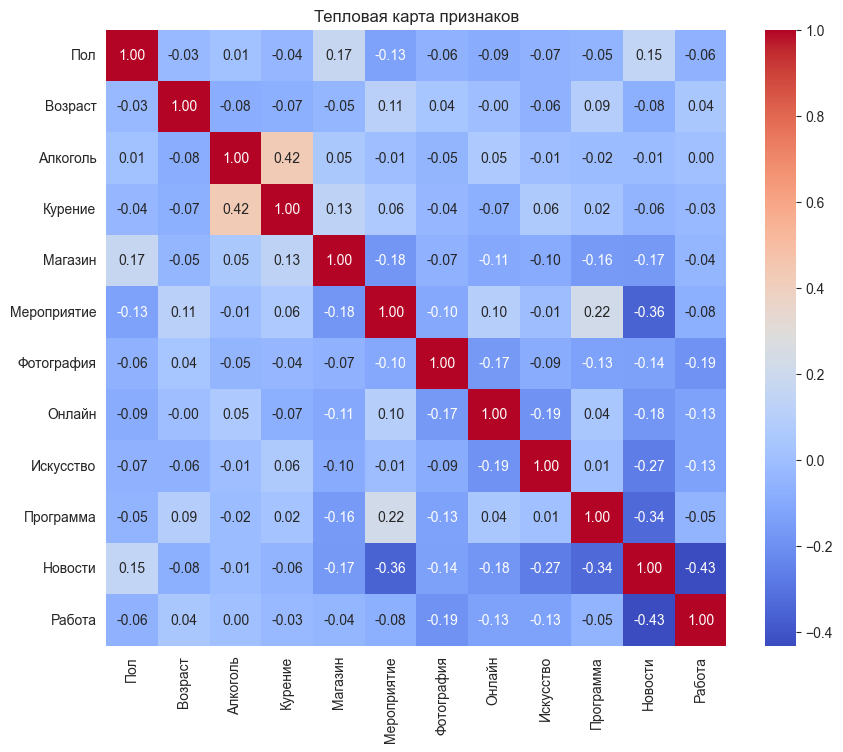

In [132]:
# Создаем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта признаков')
plt.show()

### Применение K-means

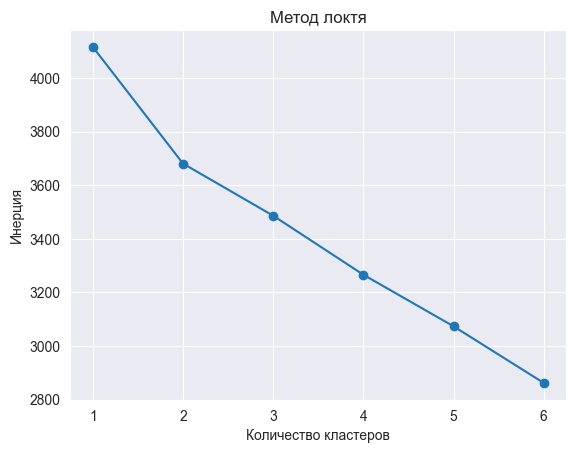

In [133]:
# Пустой список для сохранения значений инерции
inertia = []

# Пробуем разное количество кластеров от 1 до 6
for k in range(1, 7):
    # Создаем модель KMeans с текущим количеством кластеров
    model = KMeans(n_clusters=k, random_state=42)
    # Обучаем модель на данных
    model.fit(df)
    # Сохраняем значение инерции для текущего числа кластеров
    inertia.append(model.inertia_)

# Строим график метода локтя
plt.plot(range(1, 7), inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя')
plt.show()

In [134]:
model = KMeans(n_clusters=6)
model.fit(df)

KMeans(n_clusters=6)

In [135]:
old_df["Группа"] = model.labels_

old_df

,Подписчики,Общие друзья,Пол,Имя,Фамилия,Возраст,Алкоголь,Курение,Магазин,Мероприятие,Фотография,Онлайн,Искусство,Программа,Новости,Работа,Группа
id,,,,,,,,,,,,,,,,,
800367,741,2,2,Виталий,Чоботок,38.0,3.0,3.0,0.0,11.0,28.0,6.0,17.0,0.0,17.0,22.0,3
3677059,309,3,1,Анастасия,Мехова,38.0,3.0,3.0,0.0,19.0,0.0,0.0,0.0,12.0,23.0,46.0,0
5243790,703,3,2,Дмитрий,Федин,38.0,3.0,3.0,17.0,2.0,13.0,6.0,0.0,2.0,39.0,20.0,1
8888273,1389,0,2,Евгений,Высоков,38.0,3.0,3.0,2.0,9.0,9.0,2.0,0.0,0.0,58.0,19.0,1
10738440,530,1,2,Никита,Гапон,25.0,3.0,3.0,12.0,1.0,5.0,11.0,2.0,2.0,42.0,25.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679360,795,1,2,Александр,Гончаров,38.0,3.0,3.0,5.0,11.0,4.0,3.0,6.0,7.0,47.0,18.0,1
1685737,4384,1,1,Ольга,Трофимова,38.0,3.0,3.0,4.0,8.0,18.0,7.0,20.0,7.0,19.0,16.0,0
1688008,1402,1,1,Ирина,Михайлова,38.0,3.0,3.0,6.0,15.0,5.0,3.0,21.0,23.0,5.0,22.0,4


In [136]:
old_df['Группа'].value_counts()

Группа
0    99
1    92
5    45
2    38
4    36
3    33
Name: count, dtype: int64

In [137]:
# Список столбцов, для которых нужно вычислить среднее значение
columns_to_mean = ['Подписчики', 'Общие друзья', 'Пол', 'Возраст',                   'Алкоголь', 'Курение',
                   'Магазин', 'Мероприятие', 'Фотография', 'Онлайн',
                   'Искусство', 'Программа', 'Новости', 'Группа','Работа']

# Группировка данных по столбцу 'Группа' и вычисление средних значений для каждой группы
mean_df = old_df.groupby('Группа')[columns_to_mean].mean()

mean_df

,Подписчики,Общие друзья,Пол,Возраст,Алкоголь,Курение,Магазин,Мероприятие,Фотография,Онлайн,Искусство,Программа,Новости,Группа,Работа
Группа,,,,,,,,,,,,,,,
0,1584.282828,6.010101,1.070707,35.151515,3.020202,2.979798,5.191919,12.868687,11.636364,10.818182,8.404040,6.282828,20.454545,0.0,24.252525
1,889.717391,9.945652,1.663043,36.717391,3.032609,2.978261,3.815217,3.978261,10.217391,6.608696,3.173913,2.184783,54.565217,1.0,15.445652
2,855.657895,5.552632,1.947368,32.026316,3.210526,3.394737,27.684211,3.710526,7.631579,7.052632,5.184211,2.000000,28.315789,2.0,18.500000
3,2524.545455,2.272727,1.757576,35.636364,3.000000,2.969697,4.181818,8.787879,7.030303,4.363636,31.484848,5.757576,21.848485,3.0,16.727273
4,1838.888889,6.416667,1.666667,38.472222,3.027778,3.027778,4.611111,13.638889,6.527778,10.138889,5.166667,24.361111,20.277778,4.0,15.388889
5,1073.422222,7.888889,1.911111,33.955556,2.822222,2.377778,5.133333,4.000000,7.155556,10.755556,3.133333,4.866667,24.577778,5.0,40.333333


<Axes: xlabel='Группа'>

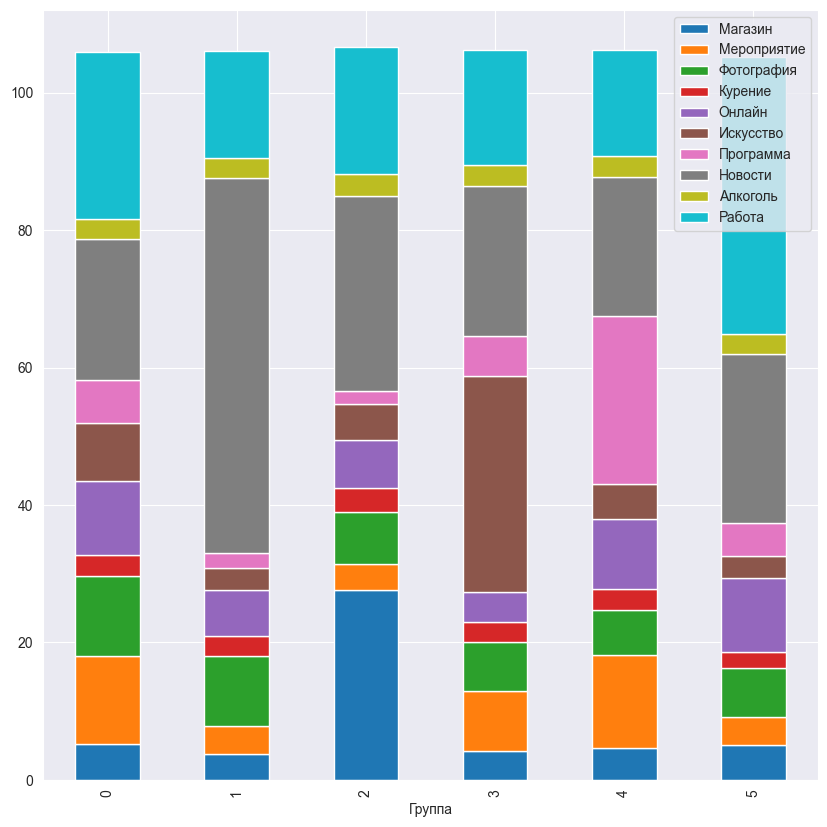

In [138]:
# Применение reset_index() для получения DataFrame без индекса
mean_df_reset = mean_df.reset_index(drop=True)

# Добавление столбца 'Группа'
mean_df_reset['Группа'] = mean_df.index

# Выбор нужных столбцов и построение столбчатой диаграммы
mean_df_reset[
    [
        'Группа', 'Магазин', 'Мероприятие', 'Фотография', 'Курение',
        'Онлайн', 'Искусство', 'Программа', 'Новости', 'Алкоголь', 'Работа'
    ]
].plot.bar(
    x='Группа',  # Используем столбец 'Группа' в качестве оси x
    stacked=True,
    figsize=(10, 10)
)


In [139]:
# Интерпретация полов
old_df.loc[old_df["Пол"] == 1, "Пол"] = "Женский"
old_df.loc[old_df["Пол"] == 2, "Пол"] = "Мужской"

/var/folders/p7/ftvgtpd17gn8nl3x825cfq8m0000gn/T/ipykernel_5391/1195945072.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Женский' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  old_df.loc[old_df["Пол"] == 1, "Пол"] = "Женский"


In [143]:
clusters = {
    "Работа и Новости": old_df[old_df["Группа"] == 0],
    "Новости": old_df[old_df["Группа"] == 1],
    "Магазин и Работа": old_df[old_df["Группа"] == 2],
    "Искусство": old_df[old_df["Группа"] == 3],
    "Программа": old_df[old_df["Группа"] == 4],
    "Работа": old_df[old_df["Группа"] == 5],
    }

## Подбор целевой аудитории

In [144]:
interests_dropdown = widgets.Dropdown(
    options=clusters.keys(),
    value=list(clusters.keys())[0],
    description="Интересы:"
    )

age_dropdown = widgets.Dropdown(
    options=["Любой", "Только 18+"],
    value="Любой",
    description="Возраст:"
    )

gender_dropdown = widgets.Dropdown(
    options=["Любой", "Мужской", "Женский"],
    value="Любой",
    description="Пол:"
    )

generate_button = widgets.Button(description='Сформировать список')

def filter_data(_):
    selected_cluster = clusters[interests_dropdown.value]
    if age_dropdown.value == "Только 18+":
        selected_cluster = selected_cluster[selected_cluster["Возраст"] >= 18]
    if gender_dropdown.value != "Любой":
        selected_cluster = selected_cluster[selected_cluster["Пол"] == gender_dropdown.value]
    print(selected_cluster[["Имя", "Фамилия", "Возраст", "Пол"]])
    print(list(selected_cluster.index))

generate_button.on_click(filter_data)

widgets.VBox([interests_dropdown, age_dropdown, gender_dropdown, generate_button])

In [142]:
import ipywidgets as widgets

# Преобразование данных в список строк
users_list = old_df['Фамилия'].tolist()

# Создание виджета выпадающего списка для выбора пользователя
user_dropdown = widgets.Dropdown(options=users_list, description="Пользователь:")

# Создание функции для фильтрации данных и вывода информации о кластере
def filter_data(_):
    user = user_dropdown.value
    # Здесь вы можете получить индекс выбранного пользователя в списке пользователей
    user_index = users_list.index(user)
    # И затем получить значение кластера из словаря по индексу
    cluster_name = list(clusters.keys())[user_index]
    print(f"Рекомендации для пользователя {user}: {cluster_name}")

# Создание кнопки "Сформировать список"
generate_button = widgets.Button(description='Сформировать список')
generate_button.on_click(filter_data)

# Отображение виджетов вертикально
widgets.VBox([user_dropdown, generate_button])
